In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
import tensorflow as tf
import tensorflow.math as tfmath
import tensorflow.keras as keras
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk

2024-09-08 19:47:21.951307: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-08 19:47:22.024317: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU, Input, LSTM, Flatten, Concatenate, Dense, Conv2D, TimeDistributed, MaxPooling2D, ReLU, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision
from qkeras import QActivation, QDense, QConv2D, QBatchNormalization, QConv2DBatchnorm
from qkeras import quantized_relu, quantized_bits
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1


2024-09-08 19:47:30.866279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-08 19:47:30.885171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-08 19:47:30.885409: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
# import argparse
# import h5py
# from sklearn.model_selection import train_test_split
# import numpy as np

# def create_datasets_dense(bkg_file, output_bkg_name, signals_files, output_signal_names, events=None, test_size=0.2, val_size=0.2, input_shape=57):
    
#     # read BACKGROUND data
#     with h5py.File(bkg_file, 'r') as file:
#         full_data = file['Particles'][:,:,:-1]
#         np.random.shuffle(full_data)
#         if events: full_data = full_data[:events,:,:]
    
#     # define training, test and validation datasets
#     X_train, X_test = train_test_split(full_data, test_size=test_size, shuffle=True)
#     X_train, X_val = train_test_split(X_train, test_size=val_size)

#     del full_data
    
#     # flatten the data for model input
#     X_train = X_train.reshape(X_train.shape[0], input_shape)
#     X_test = X_test.reshape(X_test.shape[0], input_shape)
#     X_val = X_val.reshape(X_val.shape[0], input_shape)
    
#     with h5py.File(output_bkg_name + '_dataset.h5', 'w') as h5f:
#         h5f.create_dataset('X_train', data = X_train)
#         h5f.create_dataset('X_test', data = X_test)
#         h5f.create_dataset('X_val', data = X_val)
    
#     if signals_files:
#         # read SIGNAL data
#         for i, signal_file in enumerate(signals_files):
#             f = h5py.File(signal_file,'r')
#             signal_data = f['Particles'][:,:,:-1]
#             signal_data = signal_data.reshape(signal_data.shape[0],input_shape)
#             with h5py.File(output_signal_names[i] + '_dataset.h5', 'w') as h5f2:
#                 h5f2.create_dataset('Data', data = signal_data)        
#     return
# bkg_file = "/eos/user/h/hjia/AnomalyDetection/40MHZ_data/background_for_training.h5"
# output_bkg_name = "SM_ZeroBias"

# create_datasets_dense(bkg_file, output_bkg_name, signals_files, output_signal_names)

In [5]:
filename = "/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/SM_ZeroBias_dataset.h5"
with h5py.File(filename, 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

In [6]:
X_train = np.vstack((X_train, X_val))
print(X_train.shape)

(3200000, 57)


In [7]:
def scale_columns(arr):
    # Check if the input array has 57 columns
    if arr.shape[1] != 57:
        raise ValueError("Input array must have 57 columns")
    
    # Create a copy of the input array to avoid modifying the original
    scaled_arr = arr.copy()
    
    # Define the scaling factors for each column
    scale_dict = {
        0: 1/512,
        3: 1/128, 6: 1/128, 9: 1/128, 12: 1/128, 15: 1/128,
        18: 1/128, 21: 1/128, 24: 1/128,
        27: 1/256, 30: 1/256, 33: 1/256, 36: 1/256, 39: 1/256, 42: 1/256,
        45: 1/32, 48: 1/32, 51: 1/32, 54: 1/32
    }

    # Apply scaling to the specified columns
    for col, scale_factor in scale_dict.items():
        scaled_arr[:, col] *= scale_factor
    
    return scaled_arr
X_train = scale_columns(X_train)
X_test = scale_columns(X_test)

In [8]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [9]:
def analyze_columns(arr):
    # Check if the input array has 57 columns
    if arr.shape[1] != 57:
        raise ValueError("Input array must have 57 columns")

    for col in range(57):
        column = arr[:, col]
        
        # Calculate statistics
        mean_val = np.mean(column)
        min_val = np.min(column)
        max_val = np.max(column)
        has_nan = np.isnan(column).any()
        
        # Print results
        print(f"Column {col + 1}:")
        print(f"  Mean: {mean_val:.4f}")
        print(f"  Min: {min_val:.4f}")
        print(f"  Max: {max_val:.4f}")
        print(f"  Contains NaN: {has_nan}")
        print()  # Empty line for readability
analyze_columns(X_train)

Column 1:
  Mean: 0.0810
  Min: 0.0000
  Max: 2.2795
  Contains NaN: False

Column 2:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 3:
  Mean: 0.0010
  Min: -3.1416
  Max: 3.1416
  Contains NaN: False

Column 4:
  Mean: 0.1598
  Min: 0.0000
  Max: 8.0595
  Contains NaN: False

Column 5:
  Mean: -0.0001
  Min: -3.0000
  Max: 3.0000
  Contains NaN: False

Column 6:
  Mean: 0.0005
  Min: -3.1416
  Max: 3.1416
  Contains NaN: False

Column 7:
  Mean: 0.0002
  Min: 0.0000
  Max: 1.2867
  Contains NaN: False

Column 8:
  Mean: -0.0000
  Min: -2.9988
  Max: 2.9989
  Contains NaN: False

Column 9:
  Mean: 0.0000
  Min: -3.1414
  Max: 3.1414
  Contains NaN: False

Column 10:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.3428
  Contains NaN: False

Column 11:
  Mean: -0.0000
  Min: -2.9841
  Max: 2.9868
  Contains NaN: False

Column 12:
  Mean: -0.0000
  Min: -3.1366
  Max: 3.1340
  Contains NaN: False

Column 13:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.1266
  Contains NaN: Fals

In [10]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def Qmake_encoder_set_weights(input_dim,h_dim_1,h_dim_2,h_dim_3,latent_dim):
    l2_factor = 1e-3
    inputs = keras.Input(shape=(input_dim))
    x = BatchNormalization(name="BN0")(inputs)
    x = Dense(h_dim_1,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor),
             name = "dense1")(x)
    x = BatchNormalization(name="BN1")(x)
    x = ReLU(name="relu1")(x)
    x = Dense(h_dim_2,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor),
             name = "dense2")(x)    
    x = BatchNormalization(name="BN2")(x)
    x = ReLU(name="relu2")(x)
    x = Dense(h_dim_3,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor),
             name = "dense3")(x)    
    x = BatchNormalization(name="BN3")(x)
    x = ReLU(name="relu3")(x)
    z_mean=Dense(latent_dim, name='z_mean',
                  kernel_initializer=keras.initializers.HeNormal(seed=None),
                  bias_initializer=keras.initializers.Zeros(),
                  kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z_logvar=Dense(latent_dim, name='z_log_var',
                          kernel_initializer=keras.initializers.Zeros(),
                          bias_initializer=keras.initializers.Zeros(),
                          kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z=Sampling()([z_mean,z_logvar])
    encoder = keras.Model(inputs,[z_mean,z_logvar,z],name='encoder')
    return encoder

def Qmake_decoder_set_weights(input_dim,h_dim_1,h_dim_2,h_dim_3,latent_dim):
    l2_factor = 1e-3
    inputs=keras.Input(shape=(latent_dim))
    x=layers.Dense(h_dim_3,
                   activation='relu',
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(inputs)
    x=layers.Dense(h_dim_2,
                   activation='relu',
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    x=layers.Dense(h_dim_1,
                   activation='relu',
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z=layers.Dense(input_dim,
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    decoder=keras.Model(inputs,z,name='decoder')
    return decoder
def custom_mse_loss_with_multi_index_scaling(masked_data, masked_reconstruction):
    jet_scale = 256/64
    tau_scale = 128/64
    muon_scale = 32/64
    met_scale = 512/64
    em_scale = 128/64
#     jet_scale = 1
#     tau_scale = 1
#     muon_scale = 1
#     met_scale = 1
#     em_scale = 1
    # Define the indices and their corresponding scale factors
    scale_dict = {
        0: met_scale,
        3: em_scale,
        6: em_scale,
        9: em_scale,
        12: em_scale,
        15: tau_scale,
        18: tau_scale,
        21: tau_scale,
        24: tau_scale,
        27: jet_scale,
        30: jet_scale,
        33: jet_scale,
        36: jet_scale,
        39: jet_scale,
        42: jet_scale,
        45: muon_scale,
        48: muon_scale,
        51: muon_scale,
        54: muon_scale
    }
    
    # Create the scaling tensor
    scale_tensor = tf.ones_like(masked_data)
    
    for index, factor in scale_dict.items():
        # Create a mask for the current index
        index_mask = tf.one_hot(index, depth=tf.shape(masked_data)[-1])
        # Update the scale tensor for this index
        scale_tensor += index_mask * (factor - 1)
    
    # Apply scaling
    scaled_data = masked_data * scale_tensor
    scaled_reconstruction = masked_reconstruction * scale_tensor
    
    # Calculate MSE using keras.losses.mse
    mse = keras.losses.mse(scaled_data, scaled_reconstruction)
    
    # Take the mean across all dimensions
    return tf.reduce_sum(mse)

class VAE_Model(keras.Model):
    def __init__(self, encoder, decoder, steps_per_epoch, cycle_length=10, min_beta=0.1, max_beta=0.85, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta_tracker = keras.metrics.Mean(name="beta")
        self.steps_per_epoch = steps_per_epoch
        self.cycle_length = tf.cast(cycle_length, tf.float32)
        self.min_beta = tf.cast(min_beta, tf.float32)
        self.max_beta = tf.cast(max_beta, tf.float32)
        self.beta = tf.Variable(min_beta, dtype=tf.float32)


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.beta_tracker,
        ]

    def cyclical_annealing_beta(self, epoch):
        cycle = tf.floor(1.0 + epoch / self.cycle_length)
        x = tf.abs(epoch / self.cycle_length - cycle + 1)
        return self.min_beta + (self.max_beta - self.min_beta) * tf.minimum(x, 1.0)
#     def set_beta(self,beta):
#         self.beta=beta

    def train_step(self, data):
        # Get the current epoch number
        epoch = tf.cast(self.optimizer.iterations / self.steps_per_epoch, tf.float32)
        
        # Update beta
        self.beta.assign(self.cyclical_annealing_beta(epoch))
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            mask = K.cast(K.not_equal(data, 0), K.floatx())
#             reconstruction_loss = tf.reduce_mean(keras.losses.mse(mask*data, mask*reconstruction))
            reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask*data, mask*reconstruction)
            reconstruction_loss *=(1-self.beta)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *=self.beta

            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "beta": self.beta,
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        mask = K.cast(K.not_equal(data, 0), K.floatx())
        reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask*data, mask*reconstruction)
#         reconstruction_loss = tf.reduce_mean(keras.losses.mse(mask*data, mask*reconstruction))
        reconstruction_loss*=(1-self.beta)

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)        
        kl_loss *=self.beta
        
        total_loss = reconstruction_loss + kl_loss
        
        return {
            "loss": total_loss,
            "reco_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "beta": self.beta,
        }

    def call(self, data):
        z_mean,z_log_var,x = self.encoder(data)
        reconstruction = self.decoder(x)
        return {
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "reconstruction": reconstruction
        }

        
 

In [11]:
def weighted_mse(y_true, y_pred, sample_weight):
    return tf.reduce_mean(tf.multiply(sample_weight, tf.square(y_true - y_pred)))

In [12]:
NUM_EPOCHS = 100
BATCH_SIZE = 1024
STOP_PATIENCE = 15
LR_PATIENCE = 10

In [ ]:
#TOPO 2A Trainer

T2A_enc = Qmake_encoder_set_weights(X_train.shape[1],128,64,32,16)
T2A_dec = Qmake_decoder_set_weights(X_train.shape[1],128,64,32,16)
steps_per_epoch = X_train.shape[0] // BATCH_SIZE
T2A = VAE_Model(T2A_enc, T2A_dec, steps_per_epoch=steps_per_epoch, cycle_length=10, min_beta=0.1, max_beta=0.7)
# T2A.set_beta(beta)
opt = keras.optimizers.Adam(learning_rate=0.001)
T2A.compile(optimizer=opt,weighted_metrics=[weighted_mse]) #,weighted_metrics=[weighted_mse]
# T2A.build(input_shape=(997315, 110))
T2A_enc.summary()
T2A_dec.summary()


In [14]:
early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)

callbacks = [early_stopping, reduce_lr]


tf.keras.backend.clear_session()
history = T2A.fit(x=X_train, validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True)
T2A.save_weights(filepath='/eos/user/h/hjia/AnomalyDetection/trained_models/VAE_model/versionlarge/', save_format='tf')

Epoch 1/100


2024-09-08 05:57:34.771363: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3e95512740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-08 05:57:34.771434: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-09-08 05:57:34.788974: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-08 05:57:34.958499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-09-08 05:57:35.392605: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 [==============================] - 28s 8ms/step - loss: 97.7852 - reco_loss: 96.9948 - kl_loss: 0.8702 - beta: 0.1480 - val_loss: 4.9714 - val_reco_loss: 4.1897 - val_kl_loss: 0.7816 - val_beta: 0.1480 - lr: 0.0010
Epoch 2/100
2500/2500 [==============================] - 18s 7ms/step - loss: 5.0473 - reco_loss: 4.2648 - kl_loss: 0.7907 - beta: 0.1959 - val_loss: 3.3486 - val_reco_loss: 2.5321 - val_kl_loss: 0.8165 - val_beta: 0.1959 - lr: 0.0010
Epoch 3/100
2500/2500 [==============================] - 18s 7ms/step - loss: 3.9804 - reco_loss: 3.1493 - kl_loss: 0.8512 - beta: 0.2440 - val_loss: 3.3181 - val_reco_loss: 2.4319 - val_kl_loss: 0.8862 - val_beta: 0.2440 - lr: 0.0010
Epoch 4/100
2500/2500 [==============================] - 18s 7ms/step - loss: 3.5593 - reco_loss: 2.6487 - kl_loss: 0.9276 - beta: 0.2922 - val_loss: 3.1891 - val_reco_loss: 2.2278 - val_kl_loss: 0.9613 - val_beta: 0.2922 - lr: 0.0010
Epoch 5/100
2500/2500 [==============================] - 18s 7ms/step 

Epoch 36/100
2500/2500 [==============================] - 18s 7ms/step - loss: 1.2328 - reco_loss: 0.5268 - kl_loss: 0.7124 - beta: 0.6284 - val_loss: 1.2007 - val_reco_loss: 0.4798 - val_kl_loss: 0.7209 - val_beta: 0.6284 - lr: 0.0010
Epoch 37/100
2500/2500 [==============================] - 18s 7ms/step - loss: 1.2224 - reco_loss: 0.4935 - kl_loss: 0.7345 - beta: 0.6767 - val_loss: 1.2242 - val_reco_loss: 0.4740 - val_kl_loss: 0.7502 - val_beta: 0.6767 - lr: 0.0010
Epoch 38/100
2500/2500 [==============================] - 18s 7ms/step - loss: 1.2848 - reco_loss: 0.6194 - kl_loss: 0.4815 - beta: 0.1235 - val_loss: 1.1402 - val_reco_loss: 0.9261 - val_kl_loss: 0.2142 - val_beta: 0.1235 - lr: 0.0010
Epoch 39/100
2500/2500 [==============================] - 18s 7ms/step - loss: 1.0786 - reco_loss: 0.8427 - kl_loss: 0.2538 - beta: 0.1713 - val_loss: 1.0926 - val_reco_loss: 0.8092 - val_kl_loss: 0.2834 - val_beta: 0.1713 - lr: 0.0010
Epoch 40/100
2500/2500 [==============================] 

Epoch 69/100
2500/2500 [==============================] - 18s 7ms/step - loss: 1.0489 - reco_loss: 0.5394 - kl_loss: 0.5213 - beta: 0.4118 - val_loss: 1.0852 - val_reco_loss: 0.5462 - val_kl_loss: 0.5390 - val_beta: 0.4118 - lr: 2.5000e-04
Epoch 70/100
2500/2500 [==============================] - 18s 7ms/step - loss: 1.0752 - reco_loss: 0.5189 - kl_loss: 0.5672 - beta: 0.4598 - val_loss: 1.0713 - val_reco_loss: 0.4876 - val_kl_loss: 0.5837 - val_beta: 0.4598 - lr: 2.5000e-04
Epoch 71/100
2500/2500 [==============================] - 18s 7ms/step - loss: 1.0932 - reco_loss: 0.4938 - kl_loss: 0.6094 - beta: 0.5078 - val_loss: 1.0834 - val_reco_loss: 0.4573 - val_kl_loss: 0.6261 - val_beta: 0.5078 - lr: 2.5000e-04
Epoch 72/100
2500/2500 [==============================] - 18s 7ms/step - loss: 1.1056 - reco_loss: 0.4676 - kl_loss: 0.6473 - beta: 0.5559 - val_loss: 1.0929 - val_reco_loss: 0.4288 - val_kl_loss: 0.6641 - val_beta: 0.5559 - lr: 2.5000e-04
Epoch 73/100
2494/2500 [================

In [13]:
for i in range(0,20):
    T2A_enc = Qmake_encoder_set_weights(X_train.shape[1],128,64,32,16)
    T2A_dec = Qmake_decoder_set_weights(X_train.shape[1],128,64,32,16)
    steps_per_epoch = X_train.shape[0] // BATCH_SIZE
    T2A = VAE_Model(T2A_enc, T2A_dec, steps_per_epoch=steps_per_epoch, cycle_length=10, min_beta=0.1, max_beta=0.7)
    # T2A.set_beta(beta)
    opt = keras.optimizers.Adam(learning_rate=0.001)
    T2A.compile(optimizer=opt,weighted_metrics=[weighted_mse]) #,weighted_metrics=[weighted_mse]

    early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)

    callbacks = [early_stopping, reduce_lr]


    tf.keras.backend.clear_session()
    history = T2A.fit(x=X_train, validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True)
    T2A.save_weights(filepath='/eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_{}/'.format(i), save_format='tf')

2024-09-08 19:47:44.644974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-08 19:47:44.645312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-08 19:47:44.645495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/100


2024-09-08 19:47:51.326538: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3dcd513430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-08 19:47:51.326618: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-09-08 19:47:51.335766: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-08 19:47:51.367366: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-09-08 19:47:51.546897: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 [==============================] - 27s 8ms/step - loss: 100.5634 - reco_loss: 99.5868 - kl_loss: 1.0343 - beta: 0.1480 - val_loss: 5.5481 - val_reco_loss: 4.6950 - val_kl_loss: 0.8530 - val_beta: 0.1480 - lr: 0.0010
Epoch 2/100
2500/2500 [==============================] - 19s 7ms/step - loss: 5.5224 - reco_loss: 4.6846 - kl_loss: 0.8391 - beta: 0.1960 - val_loss: 4.2257 - val_reco_loss: 3.3673 - val_kl_loss: 0.8584 - val_beta: 0.1960 - lr: 0.0010
Epoch 3/100
2500/2500 [==============================] - 18s 7ms/step - loss: 4.0422 - reco_loss: 3.1721 - kl_loss: 0.8868 - beta: 0.2440 - val_loss: 3.4205 - val_reco_loss: 2.4996 - val_kl_loss: 0.9209 - val_beta: 0.2440 - lr: 0.0010
Epoch 4/100
2500/2500 [==============================] - 18s 7ms/step - loss: 3.6251 - reco_loss: 2.6800 - kl_loss: 0.9663 - beta: 0.2918 - val_loss: 2.8973 - val_reco_loss: 1.8939 - val_kl_loss: 1.0035 - val_beta: 0.2918 - lr: 0.0010
Epoch 5/100
2500/2500 [==============================] - 19s 8ms/step

Epoch 36/100
2500/2500 [==============================] - 19s 7ms/step - loss: 1.2612 - reco_loss: 0.5501 - kl_loss: 0.7175 - beta: 0.6285 - val_loss: 1.2314 - val_reco_loss: 0.4980 - val_kl_loss: 0.7334 - val_beta: 0.6285 - lr: 0.0010
Epoch 37/100
2500/2500 [==============================] - 18s 7ms/step - loss: 1.2476 - reco_loss: 0.5119 - kl_loss: 0.7406 - beta: 0.6768 - val_loss: 1.1994 - val_reco_loss: 0.4565 - val_kl_loss: 0.7429 - val_beta: 0.6768 - lr: 0.0010
Epoch 38/100
2500/2500 [==============================] - 19s 7ms/step - loss: 1.3245 - reco_loss: 0.6509 - kl_loss: 0.4903 - beta: 0.1236 - val_loss: 1.1493 - val_reco_loss: 0.9288 - val_kl_loss: 0.2204 - val_beta: 0.1236 - lr: 0.0010
Epoch 39/100
2500/2500 [==============================] - 19s 7ms/step - loss: 1.1267 - reco_loss: 0.8887 - kl_loss: 0.2546 - beta: 0.1712 - val_loss: 1.1294 - val_reco_loss: 0.8478 - val_kl_loss: 0.2816 - val_beta: 0.1712 - lr: 0.0010
Epoch 40/100
2500/2500 [==============================] 

Epoch 69/100
2500/2500 [==============================] - 18s 7ms/step - loss: 1.0816 - reco_loss: 0.5660 - kl_loss: 0.5277 - beta: 0.4118 - val_loss: 1.0444 - val_reco_loss: 0.4956 - val_kl_loss: 0.5488 - val_beta: 0.4118 - lr: 2.5000e-04
Epoch 70/100
2500/2500 [==============================] - 19s 7ms/step - loss: 1.0933 - reco_loss: 0.5310 - kl_loss: 0.5737 - beta: 0.4598 - val_loss: 1.0767 - val_reco_loss: 0.4828 - val_kl_loss: 0.5939 - val_beta: 0.4598 - lr: 2.5000e-04
Epoch 71/100
2500/2500 [==============================] - 19s 7ms/step - loss: 1.1165 - reco_loss: 0.5103 - kl_loss: 0.6161 - beta: 0.5078 - val_loss: 1.0759 - val_reco_loss: 0.4435 - val_kl_loss: 0.6324 - val_beta: 0.5078 - lr: 2.5000e-04
Epoch 72/100
2500/2500 [==============================] - 18s 7ms/step - loss: 1.1273 - reco_loss: 0.4821 - kl_loss: 0.6543 - beta: 0.5560 - val_loss: 1.0824 - val_reco_loss: 0.4134 - val_kl_loss: 0.6689 - val_beta: 0.5560 - lr: 2.5000e-04
Epoch 73/100
2500/2500 [================

Epoch 25/100
2500/2500 [==============================] - 19s 7ms/step - loss: 1.2598 - reco_loss: 0.5147 - kl_loss: 0.7489 - beta: 0.7006 - val_loss: 1.1987 - val_reco_loss: 0.4463 - val_kl_loss: 0.7524 - val_beta: 0.7006 - lr: 0.0010
Epoch 26/100
2500/2500 [==============================] - 19s 7ms/step - loss: 2.1224 - reco_loss: 1.8623 - kl_loss: 0.2555 - beta: 0.1474 - val_loss: 1.0729 - val_reco_loss: 0.8079 - val_kl_loss: 0.2650 - val_beta: 0.1474 - lr: 0.0010
Epoch 27/100
2500/2500 [==============================] - 19s 7ms/step - loss: 1.1396 - reco_loss: 0.8567 - kl_loss: 0.2974 - beta: 0.1952 - val_loss: 1.0488 - val_reco_loss: 0.7251 - val_kl_loss: 0.3237 - val_beta: 0.1952 - lr: 0.0010
Epoch 28/100
2500/2500 [==============================] - 19s 7ms/step - loss: 1.1466 - reco_loss: 0.8054 - kl_loss: 0.3559 - beta: 0.2432 - val_loss: 1.0514 - val_reco_loss: 0.6705 - val_kl_loss: 0.3810 - val_beta: 0.2432 - lr: 0.0010
Epoch 29/100
2500/2500 [==============================] 

Epoch 58/100
2500/2500 [==============================] - 19s 7ms/step - loss: 1.0589 - reco_loss: 0.4764 - kl_loss: 0.5929 - beta: 0.4838 - val_loss: 1.0652 - val_reco_loss: 0.4578 - val_kl_loss: 0.6073 - val_beta: 0.4838 - lr: 2.5000e-04
Epoch 59/100
2500/2500 [==============================] - 19s 7ms/step - loss: 1.0736 - reco_loss: 0.4506 - kl_loss: 0.6324 - beta: 0.5318 - val_loss: 1.1070 - val_reco_loss: 0.4641 - val_kl_loss: 0.6429 - val_beta: 0.5318 - lr: 2.5000e-04
Epoch 60/100
2500/2500 [==============================] - 19s 7ms/step - loss: 1.0890 - reco_loss: 0.4297 - kl_loss: 0.6678 - beta: 0.5799 - val_loss: 1.0815 - val_reco_loss: 0.3936 - val_kl_loss: 0.6879 - val_beta: 0.5799 - lr: 2.5000e-04
Epoch 61/100
2493/2500 [============================>.] - ETA: 0s - loss: 1.1109 - reco_loss: 0.4189 - kl_loss: 0.6989 - beta: 0.6278
Epoch 61: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
2500/2500 [==============================] - 19s 7ms/step - loss: 1.1

Epoch 90/100
2500/2500 [==============================] - 19s 7ms/step - loss: 0.8562 - reco_loss: 0.5662 - kl_loss: 0.3051 - beta: 0.2200 - val_loss: 0.8856 - val_reco_loss: 0.5515 - val_kl_loss: 0.3341 - val_beta: 0.2200 - lr: 3.1250e-05
Epoch 91/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.8906 - reco_loss: 0.5407 - kl_loss: 0.3643 - beta: 0.2680 - val_loss: 0.9222 - val_reco_loss: 0.5309 - val_kl_loss: 0.3913 - val_beta: 0.2680 - lr: 3.1250e-05
Epoch 92/100
2500/2500 [==============================] - 19s 7ms/step - loss: 0.9302 - reco_loss: 0.5229 - kl_loss: 0.4210 - beta: 0.3160 - val_loss: 0.9572 - val_reco_loss: 0.5119 - val_kl_loss: 0.4453 - val_beta: 0.3160 - lr: 3.1250e-05
Epoch 93/100
2500/2500 [==============================] - 18s 7ms/step - loss: 0.9763 - reco_loss: 0.5149 - kl_loss: 0.4740 - beta: 0.3640 - val_loss: 0.9866 - val_reco_loss: 0.4900 - val_kl_loss: 0.4966 - val_beta: 0.3640 - lr: 3.1250e-05
Epoch 94/100
2500/2500 [================

Epoch 24/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.3763 - reco_loss: 0.6471 - kl_loss: 0.7338 - beta: 0.6529 - val_loss: 1.3305 - val_reco_loss: 0.5868 - val_kl_loss: 0.7437 - val_beta: 0.6529 - lr: 0.0010
Epoch 25/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.3424 - reco_loss: 0.5961 - kl_loss: 0.7490 - beta: 0.7008 - val_loss: 1.2993 - val_reco_loss: 0.5497 - val_kl_loss: 0.7497 - val_beta: 0.7008 - lr: 0.0010
Epoch 26/100
2500/2500 [==============================] - 19s 7ms/step - loss: 2.3004 - reco_loss: 2.0362 - kl_loss: 0.2592 - beta: 0.1477 - val_loss: 1.3114 - val_reco_loss: 1.0468 - val_kl_loss: 0.2646 - val_beta: 0.1477 - lr: 0.0010
Epoch 27/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.3918 - reco_loss: 1.1098 - kl_loss: 0.2976 - beta: 0.1953 - val_loss: 1.3336 - val_reco_loss: 1.0110 - val_kl_loss: 0.3226 - val_beta: 0.1953 - lr: 0.0010
Epoch 28/100
2500/2500 [==============================] 

Epoch 57/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2482 - reco_loss: 0.7116 - kl_loss: 0.5475 - beta: 0.4359 - val_loss: 1.2962 - val_reco_loss: 0.7296 - val_kl_loss: 0.5666 - val_beta: 0.4359 - lr: 2.5000e-04
Epoch 58/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2458 - reco_loss: 0.6654 - kl_loss: 0.5909 - beta: 0.4840 - val_loss: 1.2894 - val_reco_loss: 0.6824 - val_kl_loss: 0.6070 - val_beta: 0.4840 - lr: 2.5000e-04
Epoch 59/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2467 - reco_loss: 0.6258 - kl_loss: 0.6306 - beta: 0.5319 - val_loss: 1.2865 - val_reco_loss: 0.6407 - val_kl_loss: 0.6458 - val_beta: 0.5319 - lr: 2.5000e-04
Epoch 60/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2467 - reco_loss: 0.5888 - kl_loss: 0.6661 - beta: 0.5801 - val_loss: 1.2712 - val_reco_loss: 0.5901 - val_kl_loss: 0.6811 - val_beta: 0.5801 - lr: 2.5000e-04
Epoch 61/100
2494/2500 [================

Epoch 89/100
2500/2500 [==============================] - 18s 7ms/step - loss: 1.1141 - reco_loss: 0.8921 - kl_loss: 0.2382 - beta: 0.1720 - val_loss: 1.1682 - val_reco_loss: 0.8963 - val_kl_loss: 0.2719 - val_beta: 0.1720 - lr: 3.1250e-05
Epoch 90/100
2500/2500 [==============================] - 19s 7ms/step - loss: 1.1221 - reco_loss: 0.8361 - kl_loss: 0.3013 - beta: 0.2200 - val_loss: 1.1833 - val_reco_loss: 0.8515 - val_kl_loss: 0.3318 - val_beta: 0.2200 - lr: 3.1250e-05
Epoch 91/100
2500/2500 [==============================] - 19s 7ms/step - loss: 1.1434 - reco_loss: 0.7966 - kl_loss: 0.3610 - beta: 0.2680 - val_loss: 1.2053 - val_reco_loss: 0.8171 - val_kl_loss: 0.3883 - val_beta: 0.2680 - lr: 3.1250e-05
Epoch 1/100
2500/2500 [==============================] - 26s 8ms/step - loss: 92.3020 - reco_loss: 91.6453 - kl_loss: 0.7596 - beta: 0.1480 - val_loss: 5.1001 - val_reco_loss: 4.3455 - val_kl_loss: 0.7546 - val_beta: 0.1480 - lr: 0.0010
Epoch 2/100
2500/2500 [====================

Epoch 33/100
2500/2500 [==============================] - 19s 7ms/step - loss: 1.0589 - reco_loss: 0.4538 - kl_loss: 0.6150 - beta: 0.4831 - val_loss: 0.9315 - val_reco_loss: 0.3003 - val_kl_loss: 0.6312 - val_beta: 0.4831 - lr: 0.0010
Epoch 34/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0733 - reco_loss: 0.4298 - kl_loss: 0.6528 - beta: 0.5315 - val_loss: 1.0272 - val_reco_loss: 0.3615 - val_kl_loss: 0.6657 - val_beta: 0.5315 - lr: 0.0010
Epoch 35/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0901 - reco_loss: 0.4127 - kl_loss: 0.6856 - beta: 0.5794 - val_loss: 0.9676 - val_reco_loss: 0.2752 - val_kl_loss: 0.6924 - val_beta: 0.5794 - lr: 0.0010
Epoch 36/100
2499/2500 [============================>.] - ETA: 0s - loss: 1.0997 - reco_loss: 0.3922 - kl_loss: 0.7147 - beta: 0.6277
Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0997 - reco_l

Epoch 65/100
2500/2500 [==============================] - 20s 8ms/step - loss: 0.7241 - reco_loss: 0.4302 - kl_loss: 0.3098 - beta: 0.2199 - val_loss: 0.6341 - val_reco_loss: 0.2952 - val_kl_loss: 0.3389 - val_beta: 0.2199 - lr: 1.2500e-04
Epoch 66/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.7716 - reco_loss: 0.4164 - kl_loss: 0.3699 - beta: 0.2679 - val_loss: 0.6834 - val_reco_loss: 0.2878 - val_kl_loss: 0.3956 - val_beta: 0.2679 - lr: 1.2500e-04
Epoch 67/100
2500/2500 [==============================] - 19s 7ms/step - loss: 0.8136 - reco_loss: 0.4011 - kl_loss: 0.4262 - beta: 0.3159 - val_loss: 0.7306 - val_reco_loss: 0.2804 - val_kl_loss: 0.4501 - val_beta: 0.3159 - lr: 1.2500e-04
Epoch 68/100
2500/2500 [==============================] - 19s 7ms/step - loss: 0.8609 - reco_loss: 0.3942 - kl_loss: 0.4793 - beta: 0.3639 - val_loss: 0.7699 - val_reco_loss: 0.2678 - val_kl_loss: 0.5021 - val_beta: 0.3639 - lr: 1.2500e-04
Epoch 69/100
2500/2500 [================

Epoch 21/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.5465 - reco_loss: 0.8839 - kl_loss: 0.6711 - beta: 0.5084 - val_loss: 1.3944 - val_reco_loss: 0.6885 - val_kl_loss: 0.7059 - val_beta: 0.5084 - lr: 0.0010
Epoch 22/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.5162 - reco_loss: 0.8245 - kl_loss: 0.6955 - beta: 0.5563 - val_loss: 1.3566 - val_reco_loss: 0.6557 - val_kl_loss: 0.7009 - val_beta: 0.5563 - lr: 0.0010
Epoch 23/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.4429 - reco_loss: 0.7419 - kl_loss: 0.7050 - beta: 0.6046 - val_loss: 1.3087 - val_reco_loss: 0.5977 - val_kl_loss: 0.7110 - val_beta: 0.6046 - lr: 0.0010
Epoch 24/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.3713 - reco_loss: 0.6492 - kl_loss: 0.7275 - beta: 0.6523 - val_loss: 1.2284 - val_reco_loss: 0.4926 - val_kl_loss: 0.7358 - val_beta: 0.6523 - lr: 0.0010
Epoch 25/100
2500/2500 [==============================] 

Epoch 55/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0843 - reco_loss: 0.6435 - kl_loss: 0.4542 - beta: 0.3397 - val_loss: 1.0305 - val_reco_loss: 0.5499 - val_kl_loss: 0.4806 - val_beta: 0.3397 - lr: 5.0000e-04
Epoch 56/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0951 - reco_loss: 0.6022 - kl_loss: 0.5049 - beta: 0.3876 - val_loss: 1.0351 - val_reco_loss: 0.5078 - val_kl_loss: 0.5273 - val_beta: 0.3876 - lr: 5.0000e-04
Epoch 57/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1215 - reco_loss: 0.5810 - kl_loss: 0.5522 - beta: 0.4356 - val_loss: 1.0480 - val_reco_loss: 0.4763 - val_kl_loss: 0.5717 - val_beta: 0.4356 - lr: 5.0000e-04
Epoch 58/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1436 - reco_loss: 0.5578 - kl_loss: 0.5960 - beta: 0.4838 - val_loss: 1.0640 - val_reco_loss: 0.4542 - val_kl_loss: 0.6099 - val_beta: 0.4838 - lr: 5.0000e-04
Epoch 59/100
2500/2500 [================

Epoch 87/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1281 - reco_loss: 0.4043 - kl_loss: 0.7300 - beta: 0.6760 - val_loss: 1.0715 - val_reco_loss: 0.3342 - val_kl_loss: 0.7373 - val_beta: 0.6760 - lr: 6.2500e-05
Epoch 88/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0905 - reco_loss: 0.4329 - kl_loss: 0.4648 - beta: 0.1239 - val_loss: 0.7582 - val_reco_loss: 0.5514 - val_kl_loss: 0.2068 - val_beta: 0.1239 - lr: 6.2500e-05
Epoch 89/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.9079 - reco_loss: 0.6833 - kl_loss: 0.2411 - beta: 0.1719 - val_loss: 0.7882 - val_reco_loss: 0.5172 - val_kl_loss: 0.2710 - val_beta: 0.1719 - lr: 6.2500e-05
Epoch 90/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.9403 - reco_loss: 0.6515 - kl_loss: 0.3042 - beta: 0.2199 - val_loss: 0.8339 - val_reco_loss: 0.5011 - val_kl_loss: 0.3328 - val_beta: 0.2199 - lr: 6.2500e-05
Epoch 91/100
2500/2500 [================

Epoch 21/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.4690 - reco_loss: 0.8231 - kl_loss: 0.6540 - beta: 0.5085 - val_loss: 1.3981 - val_reco_loss: 0.7167 - val_kl_loss: 0.6814 - val_beta: 0.5085 - lr: 0.0010
Epoch 22/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.4473 - reco_loss: 0.7695 - kl_loss: 0.6841 - beta: 0.5562 - val_loss: 1.3895 - val_reco_loss: 0.6979 - val_kl_loss: 0.6916 - val_beta: 0.5562 - lr: 0.0010
Epoch 23/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.4160 - reco_loss: 0.7137 - kl_loss: 0.7075 - beta: 0.6044 - val_loss: 1.3527 - val_reco_loss: 0.6313 - val_kl_loss: 0.7214 - val_beta: 0.6044 - lr: 0.0010
Epoch 24/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.3637 - reco_loss: 0.6425 - kl_loss: 0.7260 - beta: 0.6525 - val_loss: 1.3633 - val_reco_loss: 0.6297 - val_kl_loss: 0.7336 - val_beta: 0.6525 - lr: 0.0010
Epoch 25/100
2500/2500 [==============================] 

Epoch 56/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1373 - reco_loss: 0.6471 - kl_loss: 0.5020 - beta: 0.3874 - val_loss: 1.1508 - val_reco_loss: 0.6299 - val_kl_loss: 0.5209 - val_beta: 0.3874 - lr: 0.0010
Epoch 57/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1589 - reco_loss: 0.6189 - kl_loss: 0.5495 - beta: 0.4358 - val_loss: 1.1389 - val_reco_loss: 0.5772 - val_kl_loss: 0.5616 - val_beta: 0.4358 - lr: 0.0010
Epoch 58/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1746 - reco_loss: 0.5918 - kl_loss: 0.5921 - beta: 0.4836 - val_loss: 1.1318 - val_reco_loss: 0.5279 - val_kl_loss: 0.6039 - val_beta: 0.4836 - lr: 0.0010
Epoch 59/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1737 - reco_loss: 0.5526 - kl_loss: 0.6304 - beta: 0.5321 - val_loss: 1.1922 - val_reco_loss: 0.5509 - val_kl_loss: 0.6413 - val_beta: 0.5321 - lr: 0.0010
Epoch 60/100
2500/2500 [==============================] 

Epoch 11/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.9643 - reco_loss: 1.0769 - kl_loss: 0.8857 - beta: 0.6288 - val_loss: 1.7193 - val_reco_loss: 0.8382 - val_kl_loss: 0.8810 - val_beta: 0.6288 - lr: 0.0010
Epoch 12/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.8401 - reco_loss: 0.9718 - kl_loss: 0.8527 - beta: 0.6769 - val_loss: 1.5962 - val_reco_loss: 0.7665 - val_kl_loss: 0.8298 - val_beta: 0.6769 - lr: 0.0010
Epoch 13/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.9091 - reco_loss: 1.1771 - kl_loss: 0.5448 - beta: 0.1239 - val_loss: 1.7771 - val_reco_loss: 1.4913 - val_kl_loss: 0.2858 - val_beta: 0.1239 - lr: 0.0010
Epoch 14/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.9015 - reco_loss: 1.5971 - kl_loss: 0.3197 - beta: 0.1717 - val_loss: 1.9346 - val_reco_loss: 1.5877 - val_kl_loss: 0.3469 - val_beta: 0.1717 - lr: 0.0010
Epoch 15/100
2500/2500 [==============================] 

Epoch 45/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1488 - reco_loss: 0.5799 - kl_loss: 0.5800 - beta: 0.4598 - val_loss: 1.2363 - val_reco_loss: 0.6355 - val_kl_loss: 0.6008 - val_beta: 0.4598 - lr: 5.0000e-04
Epoch 46/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1671 - reco_loss: 0.5555 - kl_loss: 0.6214 - beta: 0.5076 - val_loss: 1.2611 - val_reco_loss: 0.6255 - val_kl_loss: 0.6356 - val_beta: 0.5076 - lr: 5.0000e-04
Epoch 47/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1793 - reco_loss: 0.5297 - kl_loss: 0.6583 - beta: 0.5559 - val_loss: 1.2450 - val_reco_loss: 0.5722 - val_kl_loss: 0.6728 - val_beta: 0.5559 - lr: 5.0000e-04
Epoch 48/100
2498/2500 [============================>.] - ETA: 0s - loss: 1.1838 - reco_loss: 0.5005 - kl_loss: 0.6906 - beta: 0.6039
Epoch 48: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2500/2500 [==============================] - 20s 8ms/step - loss: 1.1

Epoch 77/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.9277 - reco_loss: 0.6685 - kl_loss: 0.2749 - beta: 0.1959 - val_loss: 1.1404 - val_reco_loss: 0.8332 - val_kl_loss: 0.3072 - val_beta: 0.1959 - lr: 6.2500e-05
Epoch 78/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.9586 - reco_loss: 0.6374 - kl_loss: 0.3361 - beta: 0.2439 - val_loss: 1.1544 - val_reco_loss: 0.7880 - val_kl_loss: 0.3664 - val_beta: 0.2439 - lr: 6.2500e-05
Epoch 79/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.9867 - reco_loss: 0.6070 - kl_loss: 0.3941 - beta: 0.2919 - val_loss: 1.1842 - val_reco_loss: 0.7651 - val_kl_loss: 0.4191 - val_beta: 0.2919 - lr: 6.2500e-05
Epoch 80/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0217 - reco_loss: 0.5861 - kl_loss: 0.4489 - beta: 0.3399 - val_loss: 1.1855 - val_reco_loss: 0.7127 - val_kl_loss: 0.4728 - val_beta: 0.3399 - lr: 6.2500e-05
Epoch 81/100
2500/2500 [================

Epoch 10/100
2500/2500 [==============================] - 19s 8ms/step - loss: 2.1626 - reco_loss: 1.2525 - kl_loss: 0.9025 - beta: 0.5808 - val_loss: 1.8573 - val_reco_loss: 0.9663 - val_kl_loss: 0.8910 - val_beta: 0.5808 - lr: 0.0010
Epoch 11/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.9707 - reco_loss: 1.1005 - kl_loss: 0.8547 - beta: 0.6288 - val_loss: 1.7162 - val_reco_loss: 0.8902 - val_kl_loss: 0.8260 - val_beta: 0.6288 - lr: 0.0010
Epoch 12/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.7686 - reco_loss: 0.9524 - kl_loss: 0.8089 - beta: 0.6768 - val_loss: 1.5488 - val_reco_loss: 0.7622 - val_kl_loss: 0.7866 - val_beta: 0.6768 - lr: 0.0010
Epoch 13/100
2500/2500 [==============================] - 19s 7ms/step - loss: 1.9404 - reco_loss: 1.2214 - kl_loss: 0.5500 - beta: 0.1238 - val_loss: 1.7066 - val_reco_loss: 1.3999 - val_kl_loss: 0.3067 - val_beta: 0.1238 - lr: 0.0010
Epoch 14/100
2500/2500 [==============================] 

Epoch 44/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1118 - reco_loss: 0.5937 - kl_loss: 0.5302 - beta: 0.4117 - val_loss: 1.0454 - val_reco_loss: 0.4952 - val_kl_loss: 0.5502 - val_beta: 0.4117 - lr: 5.0000e-04
Epoch 45/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1163 - reco_loss: 0.5526 - kl_loss: 0.5748 - beta: 0.4597 - val_loss: 1.0647 - val_reco_loss: 0.4751 - val_kl_loss: 0.5896 - val_beta: 0.4597 - lr: 5.0000e-04
Epoch 46/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1455 - reco_loss: 0.5386 - kl_loss: 0.6177 - beta: 0.5078 - val_loss: 1.0934 - val_reco_loss: 0.4636 - val_kl_loss: 0.6298 - val_beta: 0.5078 - lr: 5.0000e-04
Epoch 47/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1510 - reco_loss: 0.5065 - kl_loss: 0.6533 - beta: 0.5558 - val_loss: 1.1053 - val_reco_loss: 0.4362 - val_kl_loss: 0.6691 - val_beta: 0.5558 - lr: 5.0000e-04
Epoch 48/100
2500/2500 [================

Epoch 76/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.8798 - reco_loss: 0.6932 - kl_loss: 0.2066 - beta: 0.1479 - val_loss: 0.7888 - val_reco_loss: 0.5476 - val_kl_loss: 0.2413 - val_beta: 0.1479 - lr: 6.2500e-05
Epoch 77/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.8968 - reco_loss: 0.6394 - kl_loss: 0.2732 - beta: 0.1959 - val_loss: 0.8210 - val_reco_loss: 0.5169 - val_kl_loss: 0.3041 - val_beta: 0.1959 - lr: 6.2500e-05
Epoch 78/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.9358 - reco_loss: 0.6162 - kl_loss: 0.3347 - beta: 0.2440 - val_loss: 0.8599 - val_reco_loss: 0.4959 - val_kl_loss: 0.3640 - val_beta: 0.2440 - lr: 6.2500e-05
Epoch 1/100
2500/2500 [==============================] - 27s 8ms/step - loss: 130.2285 - reco_loss: 129.4634 - kl_loss: 0.8937 - beta: 0.1480 - val_loss: 5.9524 - val_reco_loss: 5.0970 - val_kl_loss: 0.8553 - val_beta: 0.1480 - lr: 0.0010
Epoch 2/100
2500/2500 [==================

Epoch 33/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2395 - reco_loss: 0.6419 - kl_loss: 0.6083 - beta: 0.4835 - val_loss: 1.2341 - val_reco_loss: 0.6093 - val_kl_loss: 0.6248 - val_beta: 0.4835 - lr: 0.0010
Epoch 34/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2480 - reco_loss: 0.6104 - kl_loss: 0.6470 - beta: 0.5320 - val_loss: 1.2383 - val_reco_loss: 0.5728 - val_kl_loss: 0.6655 - val_beta: 0.5320 - lr: 0.0010
Epoch 35/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2340 - reco_loss: 0.5607 - kl_loss: 0.6818 - beta: 0.5805 - val_loss: 1.2873 - val_reco_loss: 0.5960 - val_kl_loss: 0.6913 - val_beta: 0.5805 - lr: 0.0010
Epoch 36/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2306 - reco_loss: 0.5259 - kl_loss: 0.7118 - beta: 0.6288 - val_loss: 1.2253 - val_reco_loss: 0.5002 - val_kl_loss: 0.7251 - val_beta: 0.6288 - lr: 0.0010
Epoch 37/100
2498/2500 [============================>.] 

Epoch 65/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.9549 - reco_loss: 0.6637 - kl_loss: 0.3066 - beta: 0.2199 - val_loss: 0.9550 - val_reco_loss: 0.6185 - val_kl_loss: 0.3365 - val_beta: 0.2199 - lr: 1.2500e-04
Epoch 66/100
2500/2500 [==============================] - 20s 8ms/step - loss: 0.9891 - reco_loss: 0.6374 - kl_loss: 0.3666 - beta: 0.2679 - val_loss: 1.0233 - val_reco_loss: 0.6303 - val_kl_loss: 0.3930 - val_beta: 0.2679 - lr: 1.2500e-04
Epoch 67/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0082 - reco_loss: 0.5985 - kl_loss: 0.4236 - beta: 0.3159 - val_loss: 1.0312 - val_reco_loss: 0.5830 - val_kl_loss: 0.4483 - val_beta: 0.3159 - lr: 1.2500e-04
Epoch 68/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0504 - reco_loss: 0.5866 - kl_loss: 0.4766 - beta: 0.3639 - val_loss: 1.0650 - val_reco_loss: 0.5691 - val_kl_loss: 0.4960 - val_beta: 0.3639 - lr: 1.2500e-04
Epoch 69/100
2500/2500 [================

2500/2500 [==============================] - 20s 8ms/step - loss: 1.1022 - reco_loss: 0.4574 - kl_loss: 0.6540 - beta: 0.5560 - val_loss: 1.1240 - val_reco_loss: 0.4566 - val_kl_loss: 0.6674 - val_beta: 0.5560 - lr: 3.1250e-05
Epoch 98/100
2494/2500 [============================>.] - ETA: 0s - loss: 1.1232 - reco_loss: 0.4423 - kl_loss: 0.6894 - beta: 0.6039
Epoch 98: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1232 - reco_loss: 0.4422 - kl_loss: 0.6894 - beta: 0.6040 - val_loss: 1.1245 - val_reco_loss: 0.4235 - val_kl_loss: 0.7009 - val_beta: 0.6040 - lr: 3.1250e-05
Epoch 99/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1244 - reco_loss: 0.4110 - kl_loss: 0.7210 - beta: 0.6520 - val_loss: 1.1274 - val_reco_loss: 0.3965 - val_kl_loss: 0.7309 - val_beta: 0.6520 - lr: 1.5625e-05
Epoch 100/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1290 - reco_

Epoch 31/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.4489 - reco_loss: 0.9115 - kl_loss: 0.5507 - beta: 0.3877 - val_loss: 1.5100 - val_reco_loss: 0.9322 - val_kl_loss: 0.5777 - val_beta: 0.3877 - lr: 0.0010
Epoch 32/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.4564 - reco_loss: 0.8675 - kl_loss: 0.6011 - beta: 0.4361 - val_loss: 1.4885 - val_reco_loss: 0.8616 - val_kl_loss: 0.6269 - val_beta: 0.4361 - lr: 0.0010
Epoch 33/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.4354 - reco_loss: 0.7991 - kl_loss: 0.6471 - beta: 0.4840 - val_loss: 1.4808 - val_reco_loss: 0.8145 - val_kl_loss: 0.6663 - val_beta: 0.4840 - lr: 0.0010
Epoch 34/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.4297 - reco_loss: 0.7509 - kl_loss: 0.6882 - beta: 0.5322 - val_loss: 1.4296 - val_reco_loss: 0.7211 - val_kl_loss: 0.7085 - val_beta: 0.5322 - lr: 0.0010
Epoch 35/100
2494/2500 [============================>.] 

Epoch 63/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2287 - reco_loss: 0.5364 - kl_loss: 0.4905 - beta: 0.1239 - val_loss: 1.1534 - val_reco_loss: 0.9361 - val_kl_loss: 0.2173 - val_beta: 0.1239 - lr: 1.2500e-04
Epoch 64/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1075 - reco_loss: 0.8719 - kl_loss: 0.2527 - beta: 0.1719 - val_loss: 1.1497 - val_reco_loss: 0.8644 - val_kl_loss: 0.2853 - val_beta: 0.1719 - lr: 1.2500e-04
Epoch 65/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1558 - reco_loss: 0.8518 - kl_loss: 0.3202 - beta: 0.2199 - val_loss: 1.2404 - val_reco_loss: 0.8878 - val_kl_loss: 0.3526 - val_beta: 0.2199 - lr: 1.2500e-04
Epoch 66/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1676 - reco_loss: 0.7998 - kl_loss: 0.3835 - beta: 0.2679 - val_loss: 1.2406 - val_reco_loss: 0.8279 - val_kl_loss: 0.4127 - val_beta: 0.2679 - lr: 1.2500e-04
Epoch 67/100
2500/2500 [================

Epoch 18/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.9258 - reco_loss: 1.3801 - kl_loss: 0.5567 - beta: 0.3646 - val_loss: 1.8028 - val_reco_loss: 1.2271 - val_kl_loss: 0.5757 - val_beta: 0.3646 - lr: 0.0010
Epoch 19/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.8419 - reco_loss: 1.2558 - kl_loss: 0.5959 - beta: 0.4129 - val_loss: 1.7034 - val_reco_loss: 1.0887 - val_kl_loss: 0.6147 - val_beta: 0.4129 - lr: 0.0010
Epoch 20/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.7896 - reco_loss: 1.1672 - kl_loss: 0.6310 - beta: 0.4605 - val_loss: 1.7194 - val_reco_loss: 1.0733 - val_kl_loss: 0.6462 - val_beta: 0.4605 - lr: 0.0010
Epoch 21/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.7451 - reco_loss: 1.0897 - kl_loss: 0.6615 - beta: 0.5086 - val_loss: 1.5429 - val_reco_loss: 0.8658 - val_kl_loss: 0.6771 - val_beta: 0.5086 - lr: 0.0010
Epoch 22/100
2500/2500 [==============================] 

Epoch 53/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2569 - reco_loss: 0.9229 - kl_loss: 0.3488 - beta: 0.2437 - val_loss: 1.3900 - val_reco_loss: 1.0177 - val_kl_loss: 0.3724 - val_beta: 0.2437 - lr: 0.0010
Epoch 54/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2735 - reco_loss: 0.8803 - kl_loss: 0.4073 - beta: 0.2913 - val_loss: 1.3828 - val_reco_loss: 0.9519 - val_kl_loss: 0.4308 - val_beta: 0.2913 - lr: 0.0010
Epoch 55/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2764 - reco_loss: 0.8281 - kl_loss: 0.4617 - beta: 0.3394 - val_loss: 1.4678 - val_reco_loss: 0.9812 - val_kl_loss: 0.4866 - val_beta: 0.3394 - lr: 0.0010
Epoch 56/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2850 - reco_loss: 0.7848 - kl_loss: 0.5124 - beta: 0.3872 - val_loss: 1.5568 - val_reco_loss: 1.0259 - val_kl_loss: 0.5309 - val_beta: 0.3872 - lr: 0.0010
Epoch 57/100
2500/2500 [==============================] 

Epoch 8/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.8399 - reco_loss: 0.8858 - kl_loss: 0.9500 - beta: 0.4832 - val_loss: 1.4924 - val_reco_loss: 0.5577 - val_kl_loss: 0.9347 - val_beta: 0.4832 - lr: 0.0010
Epoch 9/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.7206 - reco_loss: 0.7839 - kl_loss: 0.9339 - beta: 0.5312 - val_loss: 1.4598 - val_reco_loss: 0.5342 - val_kl_loss: 0.9256 - val_beta: 0.5312 - lr: 0.0010
Epoch 10/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.6162 - reco_loss: 0.6933 - kl_loss: 0.9192 - beta: 0.5801 - val_loss: 1.4849 - val_reco_loss: 0.5687 - val_kl_loss: 0.9163 - val_beta: 0.5801 - lr: 0.0010
Epoch 11/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.5297 - reco_loss: 0.6298 - kl_loss: 0.8902 - beta: 0.6281 - val_loss: 1.3208 - val_reco_loss: 0.4597 - val_kl_loss: 0.8612 - val_beta: 0.6281 - lr: 0.0010
Epoch 12/100
2500/2500 [==============================] - 

Epoch 42/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.8642 - reco_loss: 0.4518 - kl_loss: 0.4255 - beta: 0.3155 - val_loss: 0.9216 - val_reco_loss: 0.4727 - val_kl_loss: 0.4490 - val_beta: 0.3155 - lr: 5.0000e-04
Epoch 43/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.8964 - reco_loss: 0.4313 - kl_loss: 0.4777 - beta: 0.3636 - val_loss: 0.9781 - val_reco_loss: 0.4749 - val_kl_loss: 0.5033 - val_beta: 0.3636 - lr: 5.0000e-04
Epoch 44/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.9339 - reco_loss: 0.4191 - kl_loss: 0.5262 - beta: 0.4116 - val_loss: 1.0276 - val_reco_loss: 0.4817 - val_kl_loss: 0.5459 - val_beta: 0.4116 - lr: 5.0000e-04
Epoch 45/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.9652 - reco_loss: 0.4050 - kl_loss: 0.5707 - beta: 0.4596 - val_loss: 0.9944 - val_reco_loss: 0.4049 - val_kl_loss: 0.5895 - val_beta: 0.4596 - lr: 5.0000e-04
Epoch 46/100
2500/2500 [================

Epoch 9/100
2500/2500 [==============================] - 19s 8ms/step - loss: 2.2432 - reco_loss: 1.3606 - kl_loss: 0.8766 - beta: 0.5325 - val_loss: 1.9968 - val_reco_loss: 1.1276 - val_kl_loss: 0.8692 - val_beta: 0.5325 - lr: 0.0010
Epoch 10/100
2500/2500 [==============================] - 19s 8ms/step - loss: 2.0551 - reco_loss: 1.1897 - kl_loss: 0.8613 - beta: 0.5806 - val_loss: 1.8480 - val_reco_loss: 1.0016 - val_kl_loss: 0.8464 - val_beta: 0.5806 - lr: 0.0010
Epoch 11/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.9156 - reco_loss: 1.0663 - kl_loss: 0.8450 - beta: 0.6288 - val_loss: 1.6894 - val_reco_loss: 0.8518 - val_kl_loss: 0.8376 - val_beta: 0.6288 - lr: 0.0010
Epoch 12/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.7847 - reco_loss: 0.9499 - kl_loss: 0.8291 - beta: 0.6767 - val_loss: 1.5825 - val_reco_loss: 0.7707 - val_kl_loss: 0.8118 - val_beta: 0.6767 - lr: 0.0010
Epoch 13/100
2500/2500 [==============================] -

Epoch 43/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2718 - reco_loss: 0.8071 - kl_loss: 0.4774 - beta: 0.3641 - val_loss: 1.4105 - val_reco_loss: 0.9071 - val_kl_loss: 0.5034 - val_beta: 0.3641 - lr: 5.0000e-04
Epoch 44/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2685 - reco_loss: 0.7537 - kl_loss: 0.5263 - beta: 0.4121 - val_loss: 1.4194 - val_reco_loss: 0.8714 - val_kl_loss: 0.5480 - val_beta: 0.4121 - lr: 5.0000e-04
Epoch 45/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2625 - reco_loss: 0.7017 - kl_loss: 0.5710 - beta: 0.4598 - val_loss: 1.3869 - val_reco_loss: 0.7964 - val_kl_loss: 0.5905 - val_beta: 0.4598 - lr: 5.0000e-04
Epoch 46/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2700 - reco_loss: 0.6670 - kl_loss: 0.6123 - beta: 0.5081 - val_loss: 1.3518 - val_reco_loss: 0.7233 - val_kl_loss: 0.6285 - val_beta: 0.5081 - lr: 5.0000e-04
Epoch 47/100
2499/2500 [================

Epoch 75/100
2500/2500 [==============================] - 20s 8ms/step - loss: 1.1628 - reco_loss: 0.4306 - kl_loss: 0.7368 - beta: 0.7000 - val_loss: 1.1472 - val_reco_loss: 0.4047 - val_kl_loss: 0.7425 - val_beta: 0.7000 - lr: 6.2500e-05
Epoch 76/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0021 - reco_loss: 0.8164 - kl_loss: 0.2065 - beta: 0.1479 - val_loss: 0.9921 - val_reco_loss: 0.7522 - val_kl_loss: 0.2399 - val_beta: 0.1479 - lr: 6.2500e-05
Epoch 77/100
2500/2500 [==============================] - 20s 8ms/step - loss: 0.9961 - reco_loss: 0.7391 - kl_loss: 0.2730 - beta: 0.1959 - val_loss: 1.0163 - val_reco_loss: 0.7129 - val_kl_loss: 0.3034 - val_beta: 0.1959 - lr: 6.2500e-05
Epoch 78/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0268 - reco_loss: 0.7072 - kl_loss: 0.3348 - beta: 0.2439 - val_loss: 1.0505 - val_reco_loss: 0.6884 - val_kl_loss: 0.3621 - val_beta: 0.2439 - lr: 6.2500e-05
Epoch 79/100
2500/2500 [================

Epoch 8/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.9154 - reco_loss: 0.9851 - kl_loss: 0.9296 - beta: 0.4837 - val_loss: 1.7243 - val_reco_loss: 0.8025 - val_kl_loss: 0.9217 - val_beta: 0.4837 - lr: 0.0010
Epoch 9/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.8202 - reco_loss: 0.8914 - kl_loss: 0.9285 - beta: 0.5318 - val_loss: 1.7513 - val_reco_loss: 0.8371 - val_kl_loss: 0.9142 - val_beta: 0.5318 - lr: 0.0010
Epoch 10/100
2500/2500 [==============================] - 20s 8ms/step - loss: 1.7153 - reco_loss: 0.7952 - kl_loss: 0.9132 - beta: 0.5806 - val_loss: 1.6273 - val_reco_loss: 0.7305 - val_kl_loss: 0.8969 - val_beta: 0.5806 - lr: 0.0010
Epoch 11/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.5915 - reco_loss: 0.7156 - kl_loss: 0.8633 - beta: 0.6284 - val_loss: 1.4404 - val_reco_loss: 0.5948 - val_kl_loss: 0.8456 - val_beta: 0.6284 - lr: 0.0010
Epoch 12/100
2500/2500 [==============================] - 

Epoch 42/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0891 - reco_loss: 0.6698 - kl_loss: 0.4333 - beta: 0.3156 - val_loss: 0.9073 - val_reco_loss: 0.4489 - val_kl_loss: 0.4585 - val_beta: 0.3156 - lr: 5.0000e-04
Epoch 43/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1165 - reco_loss: 0.6424 - kl_loss: 0.4871 - beta: 0.3636 - val_loss: 0.9541 - val_reco_loss: 0.4461 - val_kl_loss: 0.5080 - val_beta: 0.3636 - lr: 5.0000e-04
Epoch 44/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1460 - reco_loss: 0.6212 - kl_loss: 0.5367 - beta: 0.4119 - val_loss: 1.0052 - val_reco_loss: 0.4456 - val_kl_loss: 0.5595 - val_beta: 0.4119 - lr: 5.0000e-04
Epoch 45/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1641 - reco_loss: 0.5921 - kl_loss: 0.5830 - beta: 0.4597 - val_loss: 1.0199 - val_reco_loss: 0.4194 - val_kl_loss: 0.6004 - val_beta: 0.4597 - lr: 5.0000e-04
Epoch 46/100
2500/2500 [================

Epoch 74/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1407 - reco_loss: 0.4237 - kl_loss: 0.7242 - beta: 0.6520 - val_loss: 1.0672 - val_reco_loss: 0.3333 - val_kl_loss: 0.7338 - val_beta: 0.6520 - lr: 6.2500e-05
Epoch 75/100
2500/2500 [==============================] - 20s 8ms/step - loss: 1.1388 - reco_loss: 0.3959 - kl_loss: 0.7487 - beta: 0.7000 - val_loss: 1.0686 - val_reco_loss: 0.3118 - val_kl_loss: 0.7569 - val_beta: 0.7000 - lr: 6.2500e-05
Epoch 76/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.9316 - reco_loss: 0.7458 - kl_loss: 0.2089 - beta: 0.1479 - val_loss: 0.7436 - val_reco_loss: 0.4971 - val_kl_loss: 0.2466 - val_beta: 0.1479 - lr: 6.2500e-05
Epoch 77/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.9400 - reco_loss: 0.6784 - kl_loss: 0.2773 - beta: 0.1959 - val_loss: 0.8077 - val_reco_loss: 0.4993 - val_kl_loss: 0.3085 - val_beta: 0.1959 - lr: 6.2500e-05
Epoch 78/100
2500/2500 [================

Epoch 31/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1379 - reco_loss: 0.6268 - kl_loss: 0.5234 - beta: 0.3874 - val_loss: 1.3305 - val_reco_loss: 0.7915 - val_kl_loss: 0.5391 - val_beta: 0.3874 - lr: 0.0010
Epoch 32/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1513 - reco_loss: 0.5929 - kl_loss: 0.5698 - beta: 0.4352 - val_loss: 1.2520 - val_reco_loss: 0.6606 - val_kl_loss: 0.5914 - val_beta: 0.4352 - lr: 0.0010
Epoch 33/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1731 - reco_loss: 0.5707 - kl_loss: 0.6126 - beta: 0.4837 - val_loss: 1.3083 - val_reco_loss: 0.6813 - val_kl_loss: 0.6270 - val_beta: 0.4837 - lr: 0.0010
Epoch 34/100
2500/2500 [==============================] - 20s 8ms/step - loss: 1.1878 - reco_loss: 0.5453 - kl_loss: 0.6516 - beta: 0.5316 - val_loss: 1.2800 - val_reco_loss: 0.6123 - val_kl_loss: 0.6677 - val_beta: 0.5316 - lr: 0.0010
Epoch 35/100
2500/2500 [==============================] 

Epoch 63/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0589 - reco_loss: 0.3967 - kl_loss: 0.4722 - beta: 0.1238 - val_loss: 0.9053 - val_reco_loss: 0.6939 - val_kl_loss: 0.2115 - val_beta: 0.1238 - lr: 1.2500e-04
Epoch 64/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.8219 - reco_loss: 0.5920 - kl_loss: 0.2465 - beta: 0.1719 - val_loss: 0.9124 - val_reco_loss: 0.6349 - val_kl_loss: 0.2775 - val_beta: 0.1719 - lr: 1.2500e-04
Epoch 65/100
2500/2500 [==============================] - 20s 8ms/step - loss: 0.8524 - reco_loss: 0.5570 - kl_loss: 0.3112 - beta: 0.2199 - val_loss: 0.9540 - val_reco_loss: 0.6144 - val_kl_loss: 0.3396 - val_beta: 0.2199 - lr: 1.2500e-04
Epoch 66/100
2500/2500 [==============================] - 20s 8ms/step - loss: 0.9111 - reco_loss: 0.5536 - kl_loss: 0.3720 - beta: 0.2679 - val_loss: 1.0032 - val_reco_loss: 0.6046 - val_kl_loss: 0.3985 - val_beta: 0.2679 - lr: 1.2500e-04
Epoch 67/100
2500/2500 [================

2500/2500 [==============================] - 19s 8ms/step - loss: 1.0141 - reco_loss: 0.4491 - kl_loss: 0.5764 - beta: 0.4600 - val_loss: 1.0635 - val_reco_loss: 0.4680 - val_kl_loss: 0.5955 - val_beta: 0.4600 - lr: 3.1250e-05
Epoch 96/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0428 - reco_loss: 0.4336 - kl_loss: 0.6193 - beta: 0.5080 - val_loss: 1.0852 - val_reco_loss: 0.4512 - val_kl_loss: 0.6341 - val_beta: 0.5080 - lr: 3.1250e-05
Epoch 97/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0569 - reco_loss: 0.4081 - kl_loss: 0.6581 - beta: 0.5560 - val_loss: 1.0910 - val_reco_loss: 0.4206 - val_kl_loss: 0.6704 - val_beta: 0.5560 - lr: 3.1250e-05
Epoch 98/100
2499/2500 [============================>.] - ETA: 0s - loss: 1.0760 - reco_loss: 0.3915 - kl_loss: 0.6929 - beta: 0.6039
Epoch 98: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0760 - reco_l

Epoch 29/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0594 - reco_loss: 0.6603 - kl_loss: 0.4134 - beta: 0.2911 - val_loss: 0.9656 - val_reco_loss: 0.5303 - val_kl_loss: 0.4353 - val_beta: 0.2911 - lr: 0.0010
Epoch 30/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0605 - reco_loss: 0.6067 - kl_loss: 0.4668 - beta: 0.3391 - val_loss: 1.0227 - val_reco_loss: 0.5399 - val_kl_loss: 0.4828 - val_beta: 0.3391 - lr: 0.0010
Epoch 31/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0839 - reco_loss: 0.5784 - kl_loss: 0.5170 - beta: 0.3874 - val_loss: 1.0120 - val_reco_loss: 0.4722 - val_kl_loss: 0.5398 - val_beta: 0.3874 - lr: 0.0010
Epoch 32/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0985 - reco_loss: 0.5465 - kl_loss: 0.5637 - beta: 0.4352 - val_loss: 1.0315 - val_reco_loss: 0.4529 - val_kl_loss: 0.5787 - val_beta: 0.4352 - lr: 0.0010
Epoch 33/100
2500/2500 [==============================] 

2500/2500 [==============================] - 20s 8ms/step - loss: 1.0446 - reco_loss: 0.3483 - kl_loss: 0.7029 - beta: 0.6279 - val_loss: 1.0788 - val_reco_loss: 0.3679 - val_kl_loss: 0.7109 - val_beta: 0.6279 - lr: 2.5000e-04
Epoch 62/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0443 - reco_loss: 0.3205 - kl_loss: 0.7298 - beta: 0.6759 - val_loss: 1.0751 - val_reco_loss: 0.3375 - val_kl_loss: 0.7376 - val_beta: 0.6759 - lr: 1.2500e-04
Epoch 63/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.9934 - reco_loss: 0.3356 - kl_loss: 0.4678 - beta: 0.1238 - val_loss: 0.7804 - val_reco_loss: 0.5729 - val_kl_loss: 0.2075 - val_beta: 0.1238 - lr: 1.2500e-04
Epoch 64/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.6848 - reco_loss: 0.4591 - kl_loss: 0.2423 - beta: 0.1719 - val_loss: 0.8153 - val_reco_loss: 0.5425 - val_kl_loss: 0.2728 - val_beta: 0.1719 - lr: 1.2500e-04
Epoch 65/100
2500/2500 [=============================

Epoch 30/100
2500/2500 [==============================] - 20s 8ms/step - loss: 1.2387 - reco_loss: 0.7839 - kl_loss: 0.4682 - beta: 0.3394 - val_loss: 1.3536 - val_reco_loss: 0.8624 - val_kl_loss: 0.4912 - val_beta: 0.3394 - lr: 0.0010
Epoch 31/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2443 - reco_loss: 0.7377 - kl_loss: 0.5189 - beta: 0.3873 - val_loss: 1.3321 - val_reco_loss: 0.7923 - val_kl_loss: 0.5398 - val_beta: 0.3873 - lr: 0.0010
Epoch 32/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2527 - reco_loss: 0.6968 - kl_loss: 0.5671 - beta: 0.4354 - val_loss: 1.3447 - val_reco_loss: 0.7619 - val_kl_loss: 0.5828 - val_beta: 0.4354 - lr: 0.0010
Epoch 33/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2531 - reco_loss: 0.6536 - kl_loss: 0.6098 - beta: 0.4838 - val_loss: 1.2859 - val_reco_loss: 0.6614 - val_kl_loss: 0.6245 - val_beta: 0.4838 - lr: 0.0010
Epoch 34/100
2500/2500 [==============================] 

Epoch 62/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1563 - reco_loss: 0.4254 - kl_loss: 0.7373 - beta: 0.6760 - val_loss: 1.2134 - val_reco_loss: 0.4670 - val_kl_loss: 0.7464 - val_beta: 0.6760 - lr: 1.2500e-04
Epoch 63/100
2500/2500 [==============================] - 20s 8ms/step - loss: 1.1243 - reco_loss: 0.4606 - kl_loss: 0.4712 - beta: 0.1238 - val_loss: 1.0999 - val_reco_loss: 0.8899 - val_kl_loss: 0.2100 - val_beta: 0.1238 - lr: 1.2500e-04
Epoch 64/100
2500/2500 [==============================] - 20s 8ms/step - loss: 0.9611 - reco_loss: 0.7329 - kl_loss: 0.2449 - beta: 0.1719 - val_loss: 1.1496 - val_reco_loss: 0.8737 - val_kl_loss: 0.2759 - val_beta: 0.1719 - lr: 1.2500e-04
Epoch 65/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.9980 - reco_loss: 0.7047 - kl_loss: 0.3090 - beta: 0.2199 - val_loss: 1.1807 - val_reco_loss: 0.8418 - val_kl_loss: 0.3389 - val_beta: 0.2199 - lr: 1.2500e-04
Epoch 66/100
2500/2500 [================

2500/2500 [==============================] - 19s 8ms/step - loss: 3.5782 - reco_loss: 2.7070 - kl_loss: 0.8887 - beta: 0.2438 - val_loss: 2.6426 - val_reco_loss: 1.7158 - val_kl_loss: 0.9268 - val_beta: 0.2438 - lr: 0.0010
Epoch 4/100
2500/2500 [==============================] - 19s 8ms/step - loss: 2.9329 - reco_loss: 1.9896 - kl_loss: 0.9579 - beta: 0.2915 - val_loss: 2.5006 - val_reco_loss: 1.5204 - val_kl_loss: 0.9802 - val_beta: 0.2915 - lr: 0.0010
Epoch 5/100
2500/2500 [==============================] - 20s 8ms/step - loss: 2.5633 - reco_loss: 1.5808 - kl_loss: 0.9750 - beta: 0.3393 - val_loss: 2.0208 - val_reco_loss: 1.0653 - val_kl_loss: 0.9555 - val_beta: 0.3393 - lr: 0.0010
Epoch 6/100
2500/2500 [==============================] - 20s 8ms/step - loss: 2.2868 - reco_loss: 1.3479 - kl_loss: 0.9369 - beta: 0.3871 - val_loss: 1.8966 - val_reco_loss: 0.9716 - val_kl_loss: 0.9250 - val_beta: 0.3871 - lr: 0.0010
Epoch 7/100
2500/2500 [==============================] - 19s 8ms/step - 

Epoch 37/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1435 - reco_loss: 0.4034 - kl_loss: 0.7462 - beta: 0.6760 - val_loss: 1.1766 - val_reco_loss: 0.4236 - val_kl_loss: 0.7530 - val_beta: 0.6760 - lr: 5.0000e-04
Epoch 38/100
2500/2500 [==============================] - 20s 8ms/step - loss: 1.1211 - reco_loss: 0.4477 - kl_loss: 0.4816 - beta: 0.1234 - val_loss: 1.0270 - val_reco_loss: 0.8124 - val_kl_loss: 0.2145 - val_beta: 0.1234 - lr: 5.0000e-04
Epoch 39/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.8856 - reco_loss: 0.6518 - kl_loss: 0.2506 - beta: 0.1715 - val_loss: 0.9987 - val_reco_loss: 0.7171 - val_kl_loss: 0.2815 - val_beta: 0.1715 - lr: 5.0000e-04
Epoch 40/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.9187 - reco_loss: 0.6180 - kl_loss: 0.3171 - beta: 0.2195 - val_loss: 1.0930 - val_reco_loss: 0.7467 - val_kl_loss: 0.3462 - val_beta: 0.2195 - lr: 5.0000e-04
Epoch 41/100
2500/2500 [================

2500/2500 [==============================] - 19s 8ms/step - loss: 0.9839 - reco_loss: 0.4642 - kl_loss: 0.5321 - beta: 0.4119 - val_loss: 1.0768 - val_reco_loss: 0.5251 - val_kl_loss: 0.5516 - val_beta: 0.4119 - lr: 1.2500e-04
Epoch 70/100
2500/2500 [==============================] - 20s 8ms/step - loss: 1.0191 - reco_loss: 0.4511 - kl_loss: 0.5788 - beta: 0.4599 - val_loss: 1.0953 - val_reco_loss: 0.4987 - val_kl_loss: 0.5966 - val_beta: 0.4599 - lr: 1.2500e-04
Epoch 71/100
2500/2500 [==============================] - 20s 8ms/step - loss: 1.0420 - reco_loss: 0.4303 - kl_loss: 0.6219 - beta: 0.5079 - val_loss: 1.1157 - val_reco_loss: 0.4746 - val_kl_loss: 0.6412 - val_beta: 0.5079 - lr: 1.2500e-04
Epoch 72/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0577 - reco_loss: 0.4068 - kl_loss: 0.6607 - beta: 0.5560 - val_loss: 1.1088 - val_reco_loss: 0.4341 - val_kl_loss: 0.6747 - val_beta: 0.5560 - lr: 1.2500e-04
Epoch 73/100
2496/2500 [============================>

Epoch 25/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2416 - reco_loss: 0.5097 - kl_loss: 0.7351 - beta: 0.7009 - val_loss: 1.2080 - val_reco_loss: 0.4699 - val_kl_loss: 0.7381 - val_beta: 0.7009 - lr: 0.0010
Epoch 26/100
2500/2500 [==============================] - 20s 8ms/step - loss: 2.1847 - reco_loss: 1.9422 - kl_loss: 0.2369 - beta: 0.1476 - val_loss: 0.9755 - val_reco_loss: 0.7245 - val_kl_loss: 0.2510 - val_beta: 0.1476 - lr: 0.0010
Epoch 27/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1582 - reco_loss: 0.8891 - kl_loss: 0.2848 - beta: 0.1955 - val_loss: 1.1293 - val_reco_loss: 0.8157 - val_kl_loss: 0.3136 - val_beta: 0.1955 - lr: 0.0010
Epoch 28/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1615 - reco_loss: 0.8300 - kl_loss: 0.3467 - beta: 0.2435 - val_loss: 1.1390 - val_reco_loss: 0.7695 - val_kl_loss: 0.3694 - val_beta: 0.2435 - lr: 0.0010
Epoch 29/100
2500/2500 [==============================] 

Epoch 58/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0330 - reco_loss: 0.4575 - kl_loss: 0.5860 - beta: 0.4838 - val_loss: 1.0407 - val_reco_loss: 0.4392 - val_kl_loss: 0.6015 - val_beta: 0.4838 - lr: 2.5000e-04
Epoch 59/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0489 - reco_loss: 0.4337 - kl_loss: 0.6247 - beta: 0.5319 - val_loss: 1.0845 - val_reco_loss: 0.4456 - val_kl_loss: 0.6389 - val_beta: 0.5319 - lr: 2.5000e-04
Epoch 60/100
2500/2500 [==============================] - 20s 8ms/step - loss: 1.0594 - reco_loss: 0.4070 - kl_loss: 0.6601 - beta: 0.5799 - val_loss: 1.0701 - val_reco_loss: 0.3969 - val_kl_loss: 0.6732 - val_beta: 0.5799 - lr: 2.5000e-04
Epoch 61/100
2499/2500 [============================>.] - ETA: 0s - loss: 1.0761 - reco_loss: 0.3924 - kl_loss: 0.6907 - beta: 0.6279
Epoch 61: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0

Epoch 90/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.8255 - reco_loss: 0.5393 - kl_loss: 0.3012 - beta: 0.2200 - val_loss: 0.8528 - val_reco_loss: 0.5228 - val_kl_loss: 0.3301 - val_beta: 0.2200 - lr: 3.1250e-05
Epoch 91/100
2500/2500 [==============================] - 20s 8ms/step - loss: 0.8529 - reco_loss: 0.5070 - kl_loss: 0.3602 - beta: 0.2680 - val_loss: 0.8916 - val_reco_loss: 0.5060 - val_kl_loss: 0.3855 - val_beta: 0.2680 - lr: 3.1250e-05
Epoch 92/100
2500/2500 [==============================] - 20s 8ms/step - loss: 0.9032 - reco_loss: 0.5011 - kl_loss: 0.4156 - beta: 0.3160 - val_loss: 0.9239 - val_reco_loss: 0.4822 - val_kl_loss: 0.4418 - val_beta: 0.3160 - lr: 3.1250e-05
Epoch 93/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.9201 - reco_loss: 0.4648 - kl_loss: 0.4678 - beta: 0.3640 - val_loss: 0.9502 - val_reco_loss: 0.4607 - val_kl_loss: 0.4896 - val_beta: 0.3640 - lr: 3.1250e-05
Epoch 94/100
2500/2500 [================

Epoch 24/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.3020 - reco_loss: 0.5543 - kl_loss: 0.7521 - beta: 0.6524 - val_loss: 1.2088 - val_reco_loss: 0.4489 - val_kl_loss: 0.7599 - val_beta: 0.6524 - lr: 0.0010
Epoch 25/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.2755 - reco_loss: 0.5060 - kl_loss: 0.7847 - beta: 0.7011 - val_loss: 1.2060 - val_reco_loss: 0.4263 - val_kl_loss: 0.7797 - val_beta: 0.7011 - lr: 0.0010
Epoch 26/100
2500/2500 [==============================] - 19s 8ms/step - loss: 2.5723 - reco_loss: 2.3050 - kl_loss: 0.2606 - beta: 0.1476 - val_loss: 1.0693 - val_reco_loss: 0.8077 - val_kl_loss: 0.2616 - val_beta: 0.1476 - lr: 0.0010
Epoch 27/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1801 - reco_loss: 0.9008 - kl_loss: 0.2941 - beta: 0.1954 - val_loss: 1.1298 - val_reco_loss: 0.8034 - val_kl_loss: 0.3264 - val_beta: 0.1954 - lr: 0.0010
Epoch 28/100
2500/2500 [==============================] 

Epoch 57/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1019 - reco_loss: 0.5672 - kl_loss: 0.5462 - beta: 0.4359 - val_loss: 1.0315 - val_reco_loss: 0.4670 - val_kl_loss: 0.5645 - val_beta: 0.4359 - lr: 2.5000e-04
Epoch 58/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1225 - reco_loss: 0.5427 - kl_loss: 0.5903 - beta: 0.4838 - val_loss: 1.0416 - val_reco_loss: 0.4302 - val_kl_loss: 0.6114 - val_beta: 0.4838 - lr: 2.5000e-04
Epoch 59/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1309 - reco_loss: 0.5103 - kl_loss: 0.6301 - beta: 0.5319 - val_loss: 1.0717 - val_reco_loss: 0.4260 - val_kl_loss: 0.6457 - val_beta: 0.5319 - lr: 2.5000e-04
Epoch 60/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.1423 - reco_loss: 0.4843 - kl_loss: 0.6671 - beta: 0.5799 - val_loss: 1.0914 - val_reco_loss: 0.4114 - val_kl_loss: 0.6800 - val_beta: 0.5799 - lr: 2.5000e-04
Epoch 61/100
2497/2500 [================

Epoch 89/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.9044 - reco_loss: 0.6814 - kl_loss: 0.2396 - beta: 0.1720 - val_loss: 0.8400 - val_reco_loss: 0.5679 - val_kl_loss: 0.2720 - val_beta: 0.1720 - lr: 3.1250e-05
Epoch 90/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.9367 - reco_loss: 0.6492 - kl_loss: 0.3028 - beta: 0.2200 - val_loss: 0.8691 - val_reco_loss: 0.5374 - val_kl_loss: 0.3318 - val_beta: 0.2200 - lr: 3.1250e-05
Epoch 91/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.9802 - reco_loss: 0.6321 - kl_loss: 0.3625 - beta: 0.2680 - val_loss: 0.9147 - val_reco_loss: 0.5245 - val_kl_loss: 0.3902 - val_beta: 0.2680 - lr: 3.1250e-05
Epoch 92/100
2500/2500 [==============================] - 19s 8ms/step - loss: 1.0195 - reco_loss: 0.6144 - kl_loss: 0.4187 - beta: 0.3160 - val_loss: 0.9472 - val_reco_loss: 0.5039 - val_kl_loss: 0.4434 - val_beta: 0.3160 - lr: 3.1250e-05
Epoch 93/100
2500/2500 [================

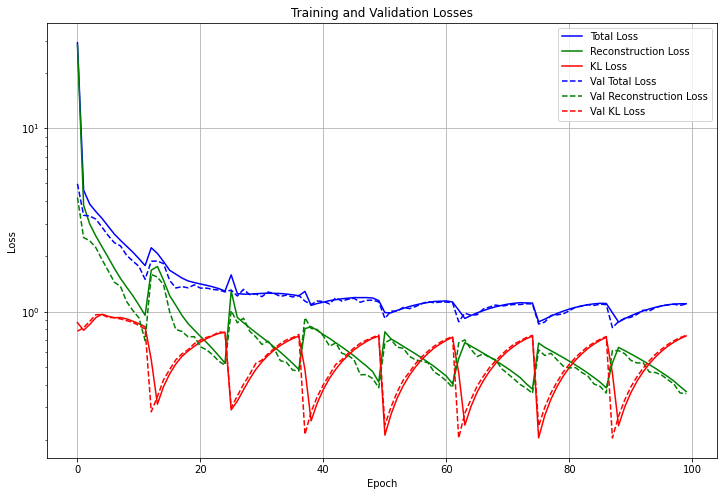

In [15]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by your model.fit() call

# Extract the loss values
total_loss = history.history['loss']
reco_loss = history.history['reco_loss']
kl_loss = history.history['kl_loss']
val_total_loss = history.history['val_loss']
val_reco_loss = history.history['val_reco_loss']
val_kl_loss = history.history['val_kl_loss']

# Create a new figure
plt.figure(figsize=(12, 8))

# Plot training losses
plt.plot(total_loss, label='Total Loss', color='blue')
plt.plot(reco_loss, label='Reconstruction Loss', color='green')
plt.plot(kl_loss, label='KL Loss', color='red')

# Plot validation losses
plt.plot(val_total_loss, label='Val Total Loss', color='blue', linestyle='--')
plt.plot(val_reco_loss, label='Val Reconstruction Loss', color='green', linestyle='--')
plt.plot(val_kl_loss, label='Val KL Loss', color='red', linestyle='--')

# Customize the plot
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [14]:
signals_file = ["/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/Ato4l_dataset.h5",
                "/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/hToTauTau_dataset.h5",
                "/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/hChToTauNu_dataset.h5",
                "/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/leptoquark_dataset.h5"]
signal_labels = ["Ato4l",
                "hToTauTau",
                "hChToTauNu",
                "leptoquark"]

In [15]:
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
#         test_data = np.array(scaler.transform(file['Data']))
        test_data = scale_columns(np.array(file['Data']))
    signal_data.append(test_data)

In [16]:
from scipy import stats

def total_loss(signal, predict, z_mean, z_log_var, beta):
    re_loss = np.mean((signal - predict) ** 2)
    kl_loss = np.sum(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))
    tot_loss = re_loss + beta * kl_loss
    return tot_loss

def AD_score(s, p, z_m, z_log, beta):
    mask = s != 0

    _s = s * mask
    _p = p * mask

    p = mask * p
    return total_loss(_s, _p, z_m, z_log, beta)


def AD_score_MSE(s, p):
    mask = s != 0
    s1 = s * mask
    p1 = p * mask
    re_loss = np.mean((s1 - p1) ** 2)
    return re_loss


def AD_score_KL(z_mean, z_log_var):
    kl_loss = np.mean(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))
    return kl_loss


def AD_score_Rz(z_mean, z_log_var):
    Rz_loss = np.mean((z_mean**2) / (np.exp(z_log_var)))
    return Rz_loss


def AD_score_CKL(z_mean, z_log_var):
    CKL = np.mean(z_mean**2)
    return CKL


class Model_Evaluator:
    def __init__(
        self,
        model_path,
        backround,
        br_weights,
        signal,
        signal_weights,
        input_dim,
        title="placeholder",
        save=False,
        labels=None,
    ):

        self.input_dim = input_dim
        #vae_enc = make_encoder_set_weights(input_dim, 128,64,32,16)
        #vae_dec = make_decoder_set_weights(input_dim, 128,64,32,16)
        vae_enc = Qmake_encoder_set_weights(input_dim, 128,64,32,16)
        vae_dec = Qmake_decoder_set_weights(input_dim, 128,64,32,16)
        self.model = VAE_Model(vae_enc, vae_dec)
        self.model.load_weights(model_path)
        self.encoder = self.model.get_layer("encoder")
        self.signal = signal
        self.backround = backround
        self.br_loss = []
        self.signal_loss = []
        self.backround_outputs = []
        self.signal_outputs = []
        self.title = title
        self.saveplots = save
        self.labels = labels
        self.latent_info = []
        self.br_weights = br_weights
        self.signal_weights = signal_weights

    def calculate_loss(self, l_type):
        self.signal_loss = []
        self.br_loss = []
        br = self.backround

        if l_type == "CKL":
            br_latent = np.array(self.encoder.predict(br))
            self.latent_info += [br_latent[0]]
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_CKL(br_latent[0][i], br_latent[1][i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_latent = np.array(self.encoder.predict(batch))
                self.latent_info += [sg_latent[0]]
                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_CKL(sg_latent[0][i], sg_latent[1][i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]

        if l_type == "KL":
            br_latent = np.array(self.encoder.predict(br))
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_KL(br_latent[0][i], br_latent[1][i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_latent = np.array(self.encoder.predict(batch))

                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_KL(sg_latent[0][i], sg_latent[1][i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]        

        if l_type == "MSE":
            br_predict = np.array(self.model.predict(br)["reconstruction"])
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_MSE(br[i], br_predict[i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_predict = np.array(self.model.predict(batch)["reconstruction"])
                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_MSE(batch[i], sg_predict[i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]

        return [self.br_loss, self.signal_loss]

    def histogram(self, bins):
        plt.hist(
            self.br_loss,
            weights=self.br_weights,
            bins=bins,
            histtype="step",
            label="backround num_events:{}".format(len(self.br_loss)),
        )
        for i, batch in enumerate(self.signal_loss):
            plt.hist(
                batch,
                weights=self.signal_weights[i],
                bins=bins,
                histtype="step",
                label=str(self.labels[i]) + " num_events:{}".format(len(batch)),
            )
        plt.xlabel("loss")
        plt.ylabel("Frequency")
        plt.yscale("log")
        plt.title("{}_Hist".format(self.title))
        plt.legend()
        if self.saveplots == True:
            plt.savefig(
                "/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_Hist.png".format(
                    self.title
                ),
                format="png",
                bbox_inches="tight",
            )
        plt.show()

    def ROC(self):
        target_fpr = 1e-5
        tpr_at_target = []
        thresholds_at_target = []

        plt.plot(
            np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--", label="diagonal"
        )
        for j, batch in enumerate(self.signal_loss):
            sig_w = self.signal_weights[j]
            br_w = self.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = []
            for i in range(len(self.br_loss)):
                truth += [0]
            for i in range(len(batch)):
                truth += [1]
            ROC_data = np.concatenate((self.br_loss, batch))
            fpr, tpr, thresholds = sk.roc_curve(truth, ROC_data, sample_weight=weights)
            # auc=np.trapz(tpr,fpr)
            auc = sk.roc_auc_score(truth, ROC_data)
            plt.plot(fpr, tpr, label=self.labels[j] + ": " + str(round(auc, 3)))
            
            idx = np.argmin(np.abs(fpr - target_fpr))
            tpr_at_target.append(tpr[idx])
            thresholds_at_target.append(thresholds[idx])


        plt.xlabel("fpr")
        plt.xlim(1e-7, 1)
        plt.ylim(1e-7, 1)
        plt.semilogx()
        plt.ylabel("tpr")
        plt.semilogy()
        plt.title("{}_ROC".format(self.title))
        plt.vlines(10**-5, 0, 1, colors="r", linestyles="dashed")
        plt.legend(loc="lower right")
        if self.saveplots == True:
            plt.savefig(
                "/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_ROC.png".format(
                    self.title
                ),
                format="png",
                bbox_inches="tight",
            )
        plt.show()
        
        print(f"\nTPR at FPR = {target_fpr} for each channel:")
        for label, tpr, threshold in zip(self.labels, tpr_at_target, thresholds_at_target):
            print(f"{label}: {tpr*100:.6f}%, Theshold = {threshold:.6f}")


    def GetPerformance(self):
        target_fpr = 1e-5
        tpr_at_target = []

        print(f"Number of signal losses: {len(self.signal_loss)}")
        print(f"Number of labels: {len(self.labels)}")
        print(f"Number of signal weights: {len(self.signal_weights)}")
        print(f"Length of br_loss: {len(self.br_loss)}")

        plt.figure(figsize=(10, 6))
        plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--", label="diagonal")

        for j, batch in enumerate(self.signal_loss):
            print(f"Processing batch {j}")
            print(f"Batch length: {len(batch)}")
            print(f"Signal weight length: {len(self.signal_weights[j])}")

            sig_w = self.signal_weights[j]
            br_w = self.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = np.concatenate([np.zeros(len(self.br_loss)), np.ones(len(batch))])
            ROC_data = np.concatenate((self.br_loss, batch))

            print(f"ROC_data shape: {ROC_data.shape}")
            print(f"truth shape: {truth.shape}")
            print(f"weights shape: {weights.shape}")

            try:
                fpr, tpr, _ = sk.roc_curve(truth, ROC_data, sample_weight=weights)
                auc = sk.roc_auc_score(truth, ROC_data)

                plt.plot(fpr, tpr, label=f"{self.labels[j]}: {auc:.3f}")

                idx = np.argmin(np.abs(fpr - target_fpr))
                tpr_at_target.append(tpr[idx])

                print(f"Successfully processed batch {j}")
            except Exception as e:
                print(f"Error processing batch {j}: {str(e)}")

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.xscale('log')
        plt.yscale('log')
        plt.title(f"{self.title} ROC")
        plt.vlines(target_fpr, 0, 1, colors="r", linestyles="dashed")
        plt.legend(loc="lower right")
        if self.saveplots:
            plt.savefig(
                f"/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{self.title}_ROC.png",
                format="png",
                bbox_inches="tight",
            )
        plt.show()

        print(f"\nTPR at FPR = {target_fpr} for each channel:")
        results = list(zip(self.labels, tpr_at_target))
        for label, tpr in results:
            print(f"{label}: {tpr:.6f}")

        print(f"Number of results: {len(results)}")
        return results

    def weighted_S_F(self, rate1):
        sf_list = []
        for j, batch in enumerate(self.signal_loss):
            sig_w = self.signal_weights[j]
            br_w = self.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = []
            for i in range(len(self.br_loss)):
                truth += [0]
            for i in range(len(batch)):
                truth += [1]
            ROC_data = np.concatenate((self.br_loss, batch))
            fpr, tpr, x = sk.roc_curve(truth, ROC_data, sample_weight=weights)
            # auc=np.trapz(tpr,fpr)
            saved = 0
            saved_index = 0
            for k, f in enumerate(fpr):
                if f > saved and f <= rate1:
                    saved = f
                    saved_index = k
            sf_list += [tpr[saved_index]]
        return sf_list



    def SIC(self):
        # plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),'--',label='diagonal')
        for j, batch in enumerate(self.signal_loss):
            truth = []
            for i in range(len(self.br_loss)):
                truth += [0]
            for i in range(len(batch)):
                truth += [1]
            ROC_data = np.concatenate((self.br_loss, batch))
            fpr, tpr, x = sk.roc_curve(truth, ROC_data)
            # auc=np.trapz(tpr,fpr)
            auc = sk.roc_auc_score(truth, ROC_data)
            plt.plot(fpr, tpr / np.sqrt(fpr), label=self.labels[j + 1])

        plt.xlabel("fpr")
        # plt.semilogx()
        plt.ylabel("trp/sqrt(fpr)")
        plt.title("{}_SIC".format(self.title))
        plt.legend()
        if self.saveplots == True:
            plt.savefig(
                "/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_SIC.png".format(
                    self.title
                ),
                format="png",
                bbox_inches="tight",
            )
        plt.show()

    def Sensitivity(self):
        # plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),'--',label='diagonal')
        for j, batch in enumerate(self.signal_loss):
            truth = []
            for i in range(len(self.br_loss)):
                truth += [0]
            for i in range(len(batch)):
                truth += [1]
            ROC_data = np.concatenate((self.br_loss, batch))
            print("NaNs in ROC_data:", np.isnan(ROC_data).any())
            print("NaNs in truth:", np.isnan(truth).any())
            if weights is not None:
                print("NaNs in weights:", np.isnan(weights).any())
            fpr, tpr, x = sk.roc_curve(truth, ROC_data)
            # auc=np.trapz(tpr,fpr)
            auc = sk.roc_auc_score(truth, ROC_data)
            plt.plot(fpr, tpr / fpr, label=self.labels[j + 1])

        plt.xlabel("fpr")
        # plt.semilogx()
        plt.ylabel("trp/fpr")
        # plt.semilogy()
        plt.title("{}_Sensitivity".format(self.title))
        plt.legend()
        if self.saveplots == True:
            plt.savefig(
                "/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_tpr_fpr.png".format(
                    self.title
                ),
                format="png",
                bbox_inches="tight",
            )
        plt.show()

    def S_F(self, true_br_rate, desired_br_rate):
        N = len(self.br_loss)
        n = int(np.round(N * (desired_br_rate / true_br_rate)))
        br = self.br_loss
        br.sort()
        AD = br[-(n + 1)]
        print(AD)
        sensitivity = []
        for i, losses in enumerate(self.signal_loss):
            N = len(losses)
            n = 0
            for loss in losses:
                if loss >= AD:
                    n += 1
            sen = n / N
            sensitivity += [sen]
        self.signal_sensitivity = sensitivity
        return self.signal_sensitivity

    def Find_AD_Cutoff(self, br_rate, desired_rate, starting_AD):
        N = self.backround.shape[0]
        AD_max = starting_AD
        AD_List = np.linspace(0, AD_max, num=1000)
        best_AD = 0
        for i, AD in enumerate(np.flip(AD_List)):
            n = 0
            for loss in self.br_loss:
                if loss >= AD:
                    n += 1
            sigrate = br_rate * n / N
            if sigrate <= desired_rate:
                best_AD = AD
            if sigrate > desired_rate:
                break
        self.AD_cutoff = best_AD
        return best_AD

    def calculate_sensitivity(self, br_rate):
        AD = self.AD_cutoff
        sensitivity = []
        for i, losses in enumerate(self.signal_loss):
            N = len(losses)
            n = 0
            for loss in losses:
                if loss >= AD:
                    n += 1
            sen = n / N
            sensitivity += [sen]
        self.signal_sensitivity = sensitivity
        print(self.signal_sensitivity)

    def event_anomally_checker(self, rate):
        N = len(self.br_loss)
        n = int(np.round(N * (rate)))
        br = self.br_loss
        br.sort()
        AD = br[-(n + 1)]
        sensitivity = []
        anomalous_events = []
        for i, losses in enumerate(self.signal_loss):
            anomalous_signs = []
            for i, loss in enumerate(losses):
                if loss >= AD:
                    anomalous_signs += [i]
            anomalous_events += [anomalous_signs]
        return anomalous_events

    def pt_correlation(self):
        pt_num = self.input_dim // 3
        print(pt_num)
        for k, sig in enumerate(self.signal):
            tot_pt_per_event = []
            for event in sig:
                pt = 0
                for i in range(0, pt_num):
                    pt += event[3 * i]
                tot_pt_per_event += [pt]
            plt.hist2d(
                tot_pt_per_event,
                self.signal_loss[k],
                cmin=1,
                bins=[np.logspace(-2, 4, 40), np.logspace(-2, 4, 40)],
                weights=self.signal_weights[k],
                norm="log",
            )
            # plt.semilogx()
            plt.xlabel("event pt")
            plt.ylabel("anomaly score")
            # plt.semilogy()
            # plt.hist(tot_pt_per_event)
            # plt.show()
            plt.colorbar()
            plt.show()
            plt.scatter(tot_pt_per_event, self.signal_loss[k])
            plt.show()

    def met_correlation(self, br_MET, signal_METs):

        plt.hist2d(
            br_MET,
            self.br_loss,
            bins=[np.logspace(-2, 4, 40), np.logspace(-2, 4, 40)],
            cmin=1,
            weights=self.br_weights,
            norm="log",
        )
        plt.semilogx()
        plt.xlabel("MET pt")
        plt.ylabel("anomaly score")
        plt.semilogy()
        plt.colorbar()
        plt.title(self.title + " backround")
        plt.show()
        for i, list in enumerate(signal_METs):

            plt.hist2d(
                list,
                self.signal_loss[i],
                bins=[np.logspace(-2, 4, 40), np.logspace(-2, 4, 40)],
                cmin=1,
                weights=self.signal_weights[i],
                norm="log",
            )
            plt.semilogx()
            plt.xlabel("MET pt")
            plt.ylabel("anomaly score")
            plt.semilogy()
            plt.colorbar()
            plt.title(self.title + " " + self.labels[i])
            plt.show()

    def plot_anomaly_score_distribution(self):
        fig, ax = plt.subplots(figsize=(12, 8))
        bins = 10000
        # Determine the range for the bins
        all_scores = np.concatenate([self.br_loss] + self.signal_loss)
        min_score, max_score = 0.01, np.max(all_scores)
        bin_edges = np.linspace(min_score, max_score, bins + 1)

        # Plot background distribution
        br_weights = self.br_weights / np.sum(self.br_weights)  # Normalize weights
        counts, _, _ = ax.hist(self.br_loss, bins=bin_edges, weights=br_weights, 
                               histtype='step', label='Background',
                               color='black', density=True, linewidth=3)

        # Plot signal distributions
        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.signal_loss)))
        for i, (signal_scores, signal_weights, label) in enumerate(zip(self.signal_loss, self.signal_weights, self.labels)):
            signal_weights = signal_weights / np.sum(signal_weights)  # Normalize weights
            ax.hist(signal_scores, bins=bin_edges, weights=signal_weights,
                    histtype='step', label=label, color=colors[i],
                    density=True, linewidth=2)

        ax.set_xlabel('Anomaly Score')
        ax.set_ylabel('Density')
        ax.set_title(f'{self.title} Anomaly Score Distribution')
        ax.legend()
        ax.grid(True, which='both', linestyle='--', alpha=0.7)

        ax.set_ylim(bottom=1e-4, top=10)

        ax.set_xscale('log')
        ax.set_yscale('log')

        if self.saveplots:
            plt.savefig(
                f"/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{self.title}_Anomaly_Score_Distribution_Histogram.png",
                format="png",
                bbox_inches="tight",
            )
        plt.show()

        # Calculate and print the mean anomaly score for each distribution
        print("\nMean Anomaly Scores:")
        print(f"Background: {np.average(self.br_loss, weights=self.br_weights):.6f}")
        for signal_scores, signal_weights, label in zip(self.signal_loss, self.signal_weights, self.labels):
            mean_score = np.average(signal_scores, weights=signal_weights)
            print(f"{label}: {mean_score:.6f}")

            

In [17]:
def read_h5_data(file_path):
    try:
        with h5py.File(file_path, 'r') as f:
#             data = scaler.transform(f['Data'])
            data =  scale_columns(np.array(f['Data']))
        return data
    except Exception as e:
        print(f"Error reading file {file_path}: {str(e)}")
        return None
Ato4l_data = read_h5_data(signals_file[0])
hToTauTau_data = read_h5_data(signals_file[1])
hChToTauNu_data = read_h5_data(signals_file[2])
leptoquark_data = read_h5_data(signals_file[3])

In [18]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def Qmake_encoder_set_weights(input_dim,h_dim_1,h_dim_2,h_dim_3,latent_dim):
    inputs = keras.Input(shape=(input_dim), name = "inputs")
    x = BatchNormalization(name="BN0")(inputs)
    x = Dense(h_dim_1,
            name = "dense1")(x)
    x = BatchNormalization(name="BN1")(x)
    x = ReLU(name = 'relu1')(x)
    x = Dense(h_dim_2,
            name = "dense2")(x)
    x = BatchNormalization(name="BN2")(x)
    x = ReLU(name = 'relu2')(x)
    x = Dense(h_dim_3,
            name = "dense3")(x)
    x = BatchNormalization(name="BN3")(x)
    x = ReLU(name = 'relu3')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_logvar = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean,z_logvar])
    encoder = keras.Model(inputs,[z_mean,z_logvar,z],name='encoder')
    return encoder

def Qmake_decoder_set_weights(input_dim,h_dim_1,h_dim_2,h_dim_3,latent_dim):
    inputs = keras.Input(shape=(latent_dim))
    x = layers.Dense(h_dim_3, activation='relu')(inputs)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    x = layers.Dense(h_dim_1, activation='relu')(x)
    z = layers.Dense(input_dim)(x)
    decoder = keras.Model(inputs,z,name='decoder')
    return decoder

class VAE_Model(keras.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta=1

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def set_beta(self,beta):
        self.beta=beta
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            #making a masked loss function
            mask = K.cast(K.not_equal(data, 0), K.floatx())
            #reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.mse(mask*data, mask*reconstruction)))
            reconstruction_loss = tf.reduce_mean(keras.losses.mse(mask*data, mask*reconstruction))
            reconstruction_loss *=(1-self.beta)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *=self.beta


            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        
        reconstruction = self.decoder(z)
        mask = K.cast(K.not_equal(data, 0), K.floatx())
        #reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.mse(mask*data, mask*reconstruction)))
        reconstruction_loss = tf.reduce_mean(keras.losses.mse(mask*data, mask*reconstruction))
        reconstruction_loss*=(1-self.beta)

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        
        #KL loss changed abck to sum as in paper
        #kl_loss = tf.reduce_sum(kl_loss)
        kl_loss = tf.reduce_mean(kl_loss)
        
        kl_loss *=self.beta
        
        total_loss = reconstruction_loss + kl_loss
        
        return {
            "loss": total_loss,
            "reco_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        z_mean,z_log_var,x = self.encoder(data)
        reconstruction = self.decoder(x)
        return {
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "reconstruction": reconstruction
        }

Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_0/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 22s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)
Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shap

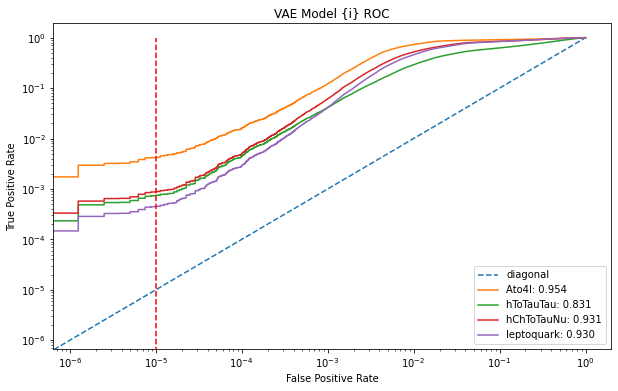


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.004181
hToTauTau: 0.000731
hChToTauNu: 0.000869
leptoquark: 0.000443
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.004180885847522736), ('hToTauTau', 0.000730525703655377), ('hChToTauNu', 0.0008694256792305912), ('leptoquark', 0.0004434081939485059)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_1/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 22s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)


Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shape: (1140544,)
weights shape: (1140544,)
Successfully processed batch 3


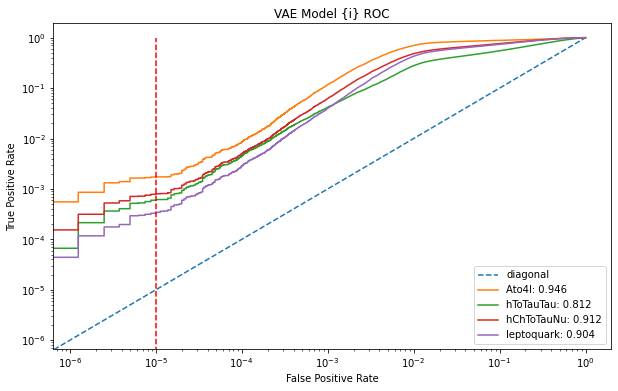


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.001715
hToTauTau: 0.000597
hChToTauNu: 0.000783
leptoquark: 0.000329
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.001715235219496507), ('hToTauTau', 0.000597439832890437), ('hChToTauNu', 0.0007826146431803354), ('leptoquark', 0.0003288855478293554)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_2/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 22s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)


Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shape: (1140544,)
weights shape: (1140544,)
Successfully processed batch 3


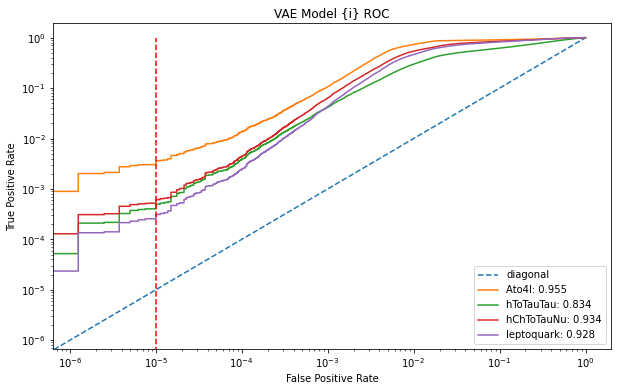


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.003037
hToTauTau: 0.000404
hChToTauNu: 0.000521
leptoquark: 0.000255
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.003037395701191731), ('hToTauTau', 0.0004035973689501984), ('hChToTauNu', 0.0005208662163015342), ('leptoquark', 0.00025547359518887425)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_3/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 22s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)

Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shape: (1140544,)
weights shape: (1140544,)
Successfully processed batch 3


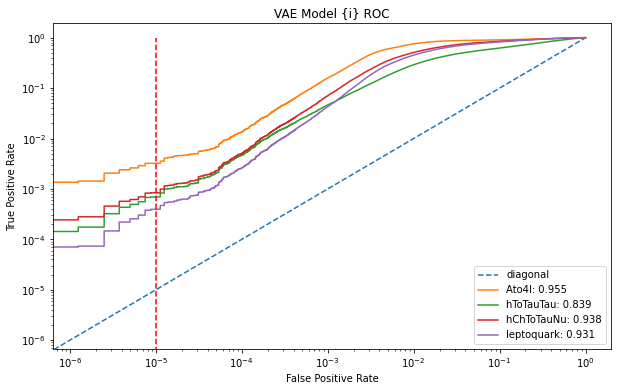


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.003216
hToTauTau: 0.000689
hChToTauNu: 0.000837
leptoquark: 0.000393
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.0032160660365559506), ('hToTauTau', 0.0006885747226533851), ('hChToTauNu', 0.0008365427110297367), ('leptoquark', 0.00039348806615297876)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_4/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 21s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,

Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shape: (1140544,)
weights shape: (1140544,)
Successfully processed batch 3


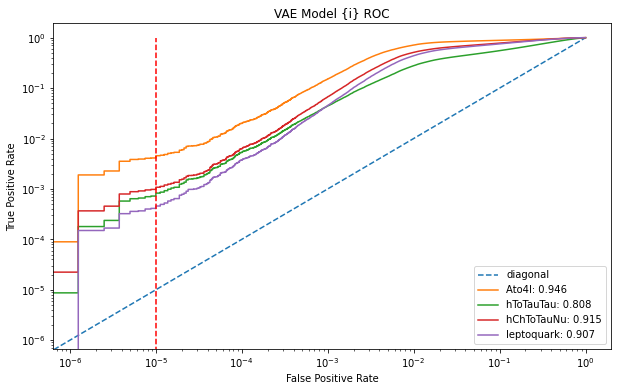


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.004109
hToTauTau: 0.000722
hChToTauNu: 0.000979
leptoquark: 0.000411
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.004109417713377048), ('hToTauTau', 0.0007218461903446201), ('hChToTauNu', 0.000978597133657428), ('leptoquark', 0.00041110693478669424)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_5/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 22s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)


Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shape: (1140544,)
weights shape: (1140544,)
Successfully processed batch 3


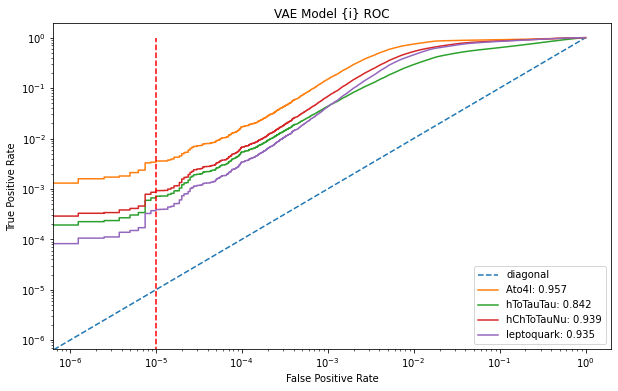


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.003395
hToTauTau: 0.000663
hChToTauNu: 0.000859
leptoquark: 0.000370
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.00339473637192017), ('hToTauTau', 0.0006625361827211142), ('hChToTauNu', 0.0008589031294063177), ('leptoquark', 0.0003699962413080248)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_6/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 22s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)


Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shape: (1140544,)
weights shape: (1140544,)
Successfully processed batch 3


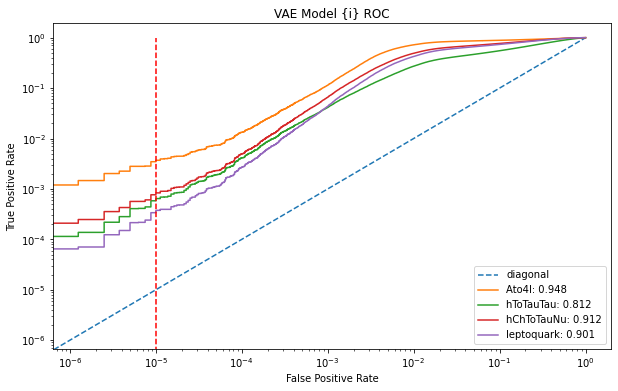


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.003466
hToTauTau: 0.000582
hChToTauNu: 0.000766
leptoquark: 0.000338
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.0034662045060658577), ('hToTauTau', 0.0005815273918207159), ('hChToTauNu', 0.0007655154997158912), ('leptoquark', 0.00033769498214621314)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_7/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 22s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,

Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shape: (1140544,)
weights shape: (1140544,)
Successfully processed batch 3


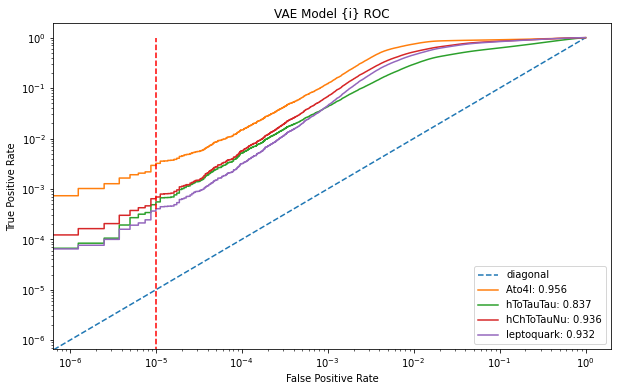


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.002930
hToTauTau: 0.000486
hChToTauNu: 0.000639
leptoquark: 0.000364
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.0029301934999731993), ('hToTauTau', 0.00048605274540238944), ('hChToTauNu', 0.0006392449018246102), ('leptoquark', 0.00036412328509678634)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_8/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 22s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283

Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shape: (1140544,)
weights shape: (1140544,)
Successfully processed batch 3


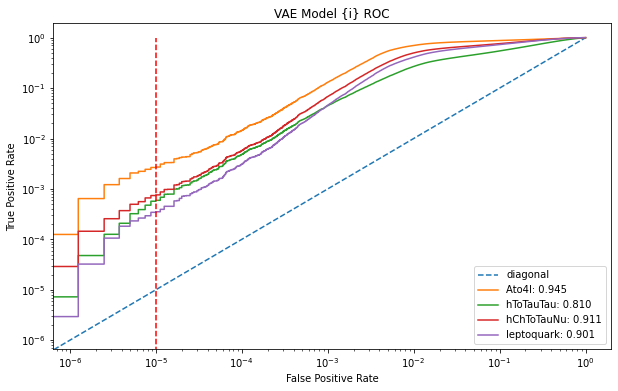


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.002662
hToTauTau: 0.000570
hChToTauNu: 0.000739
leptoquark: 0.000344
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.0026621879969268704), ('hToTauTau', 0.0005699547074063734), ('hChToTauNu', 0.0007392091251552076), ('leptoquark', 0.0003435679383574516)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_9/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 21s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)

Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shape: (1140544,)
weights shape: (1140544,)
Successfully processed batch 3


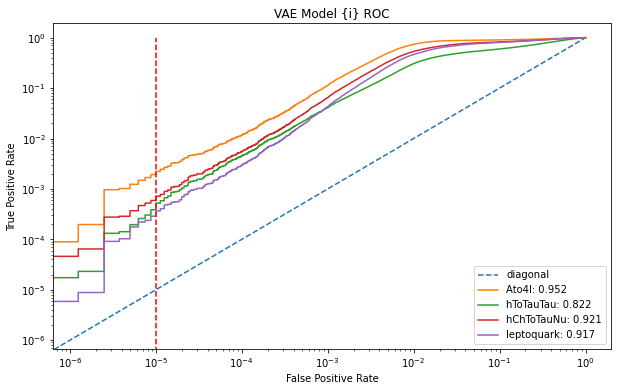


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.001930
hToTauTau: 0.000386
hChToTauNu: 0.000591
leptoquark: 0.000288
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.0019296396219335703), ('hToTauTau', 0.0003862383423286845), ('hChToTauNu', 0.0005905781088873456), ('leptoquark', 0.000287774854350686)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_10/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 21s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)

Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shape: (1140544,)
weights shape: (1140544,)
Successfully processed batch 3


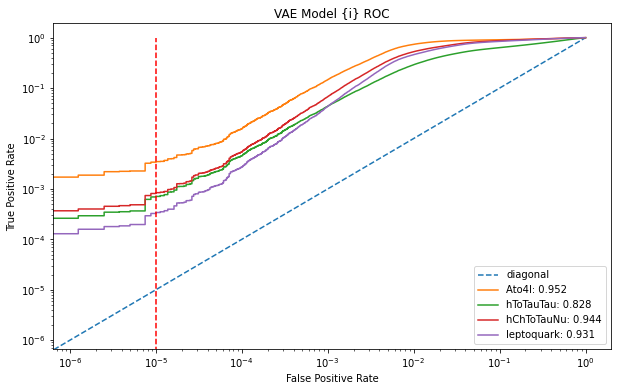


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.003395
hToTauTau: 0.000693
hChToTauNu: 0.000812
leptoquark: 0.000326
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.00339473637192017), ('hToTauTau', 0.0006929144793087636), ('hChToTauNu', 0.0008115516551970873), ('leptoquark', 0.00032594906972373614)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_11/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 21s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)

Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shape: (1140544,)
weights shape: (1140544,)
Successfully processed batch 3


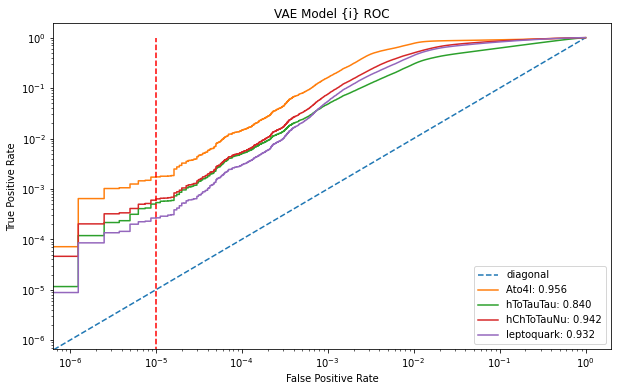


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.001715
hToTauTau: 0.000501
hChToTauNu: 0.000598
leptoquark: 0.000264
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.001715235219496507), ('hToTauTau', 0.0005005186009203178), ('hChToTauNu', 0.0005984700212555506), ('leptoquark', 0.000264283029505732)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_12/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 22s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)


Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shape: (1140544,)
weights shape: (1140544,)
Successfully processed batch 3


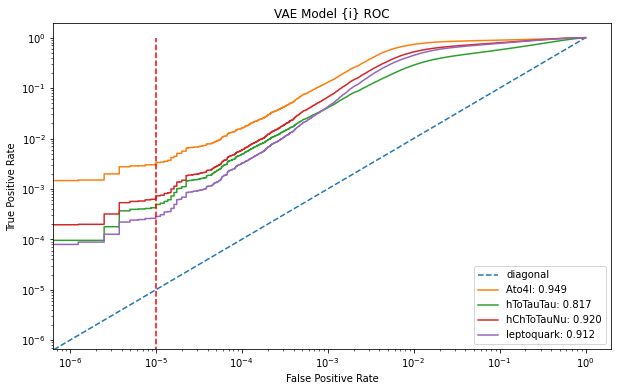


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.003020
hToTauTau: 0.000424
hChToTauNu: 0.000623
leptoquark: 0.000261
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.003019528667655309), ('hToTauTau', 0.00042384956667529795), ('hChToTauNu', 0.0006234610770882), ('leptoquark', 0.00026134655140011277)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_13/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 22s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)


Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shape: (1140544,)
weights shape: (1140544,)
Successfully processed batch 3


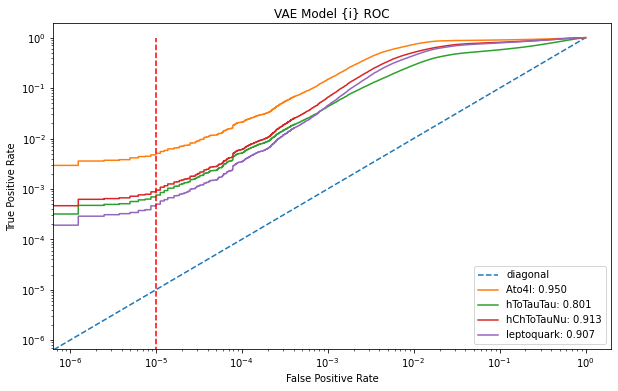


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.004735
hToTauTau: 0.000694
hChToTauNu: 0.000875
leptoquark: 0.000461
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.004734763887151816), ('hToTauTau', 0.0006943610648605564), ('hChToTauNu', 0.0008746869541427279), ('leptoquark', 0.0004610270625822214)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_14/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 22s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)

Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shape: (1140544,)
weights shape: (1140544,)
Successfully processed batch 3


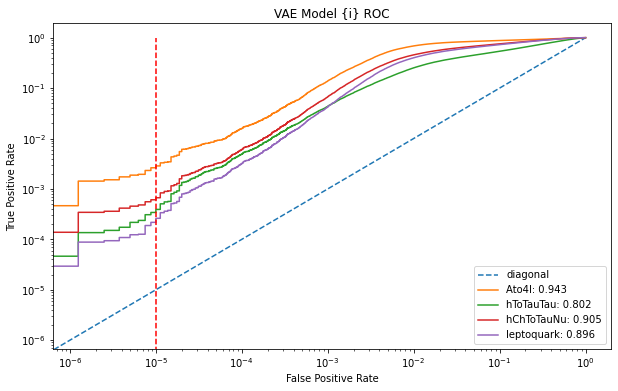


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.002626
hToTauTau: 0.000341
hChToTauNu: 0.000609
leptoquark: 0.000217
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.002626453929854026), ('hToTauTau', 0.00034139419022310687), ('hChToTauNu', 0.0006089925710798241), ('leptoquark', 0.0002172993798158241)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_15/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 22s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,

Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shape: (1140544,)
weights shape: (1140544,)
Successfully processed batch 3


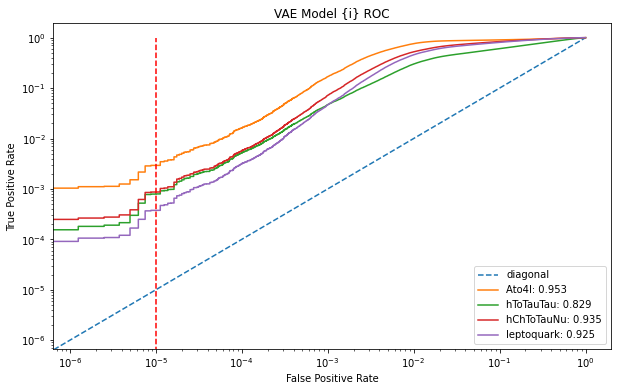


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.002930
hToTauTau: 0.000790
hChToTauNu: 0.000867
leptoquark: 0.000376
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.0029301934999731993), ('hToTauTau', 0.0007898357112788829), ('hChToTauNu', 0.0008667950417745228), ('leptoquark', 0.0003758691975192633)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_16/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 22s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,

Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shape: (1140544,)
weights shape: (1140544,)
Successfully processed batch 3


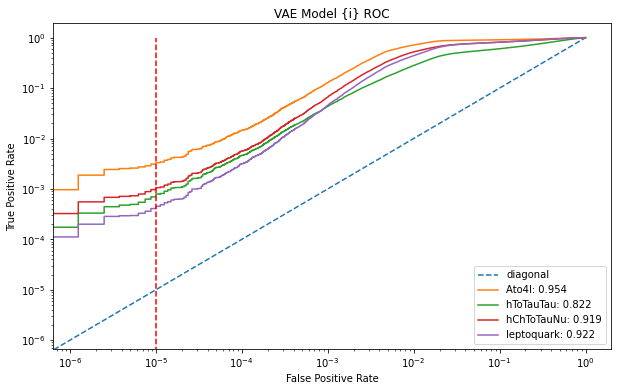


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.003109
hToTauTau: 0.000696
hChToTauNu: 0.000969
leptoquark: 0.000408
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.003108863835337419), ('hToTauTau', 0.0006958076504123492), ('hChToTauNu', 0.0009693899025611886), ('leptoquark', 0.00040817045668107497)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_17/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 22s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,

Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shape: (1140544,)
weights shape: (1140544,)
Successfully processed batch 3


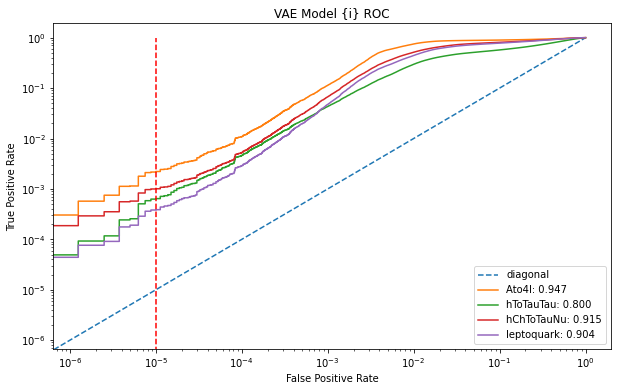


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.002162
hToTauTau: 0.000628
hChToTauNu: 0.000997
leptoquark: 0.000382
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.0021619110579070558), ('hToTauTau', 0.0006278181294780864), ('hChToTauNu', 0.0009970115958499064), ('leptoquark', 0.00038174215373050176)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_18/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 22s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283

Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shape: (1140544,)
weights shape: (1140544,)
Successfully processed batch 3


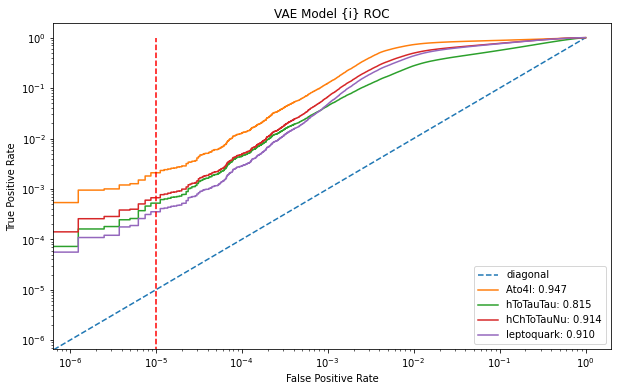


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.002090
hToTauTau: 0.000522
hChToTauNu: 0.000668
leptoquark: 0.000352
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.002090442923761368), ('hToTauTau', 0.0005222173841972101), ('hChToTauNu', 0.0006681819138413621), ('leptoquark', 0.00035237737267430934)]
Evaluating model from path: /eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_19/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 21s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,

Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data shape: (1140544,)
truth shape: (1140544,)
weights shape: (1140544,)
Successfully processed batch 3


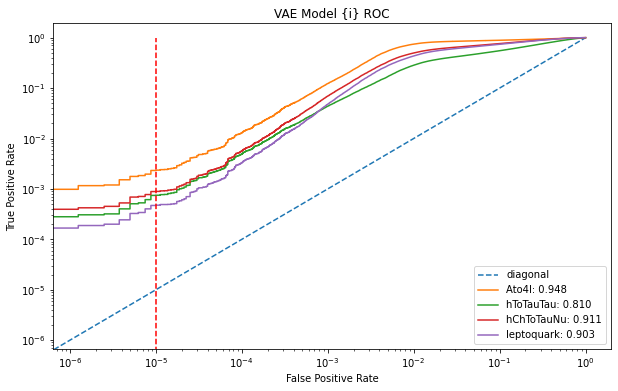


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.002323
hToTauTau: 0.000744
hChToTauNu: 0.000887
leptoquark: 0.000470
Number of results: 4
GetPerformance() returned: [('Ato4l', 0.002322714359734853), ('hToTauTau', 0.0007435449736215125), ('hChToTauNu', 0.0008865248226950354), ('leptoquark', 0.0004698364968990791)]
Final channel results: {'Ato4l': [0.004180885847522736, 0.001715235219496507, 0.003037395701191731, 0.0032160660365559506, 0.004109417713377048, 0.00339473637192017, 0.0034662045060658577, 0.0029301934999731993, 0.0026621879969268704, 0.0019296396219335703, 0.00339473637192017, 0.001715235219496507, 0.003019528667655309, 0.004734763887151816, 0.002626453929854026, 0.0029301934999731993, 0.003108863835337419, 0.0021619110579070558, 0.002090442923761368, 0.002322714359734853], 'hToTauTau': [0.000730525703655377, 0.000597439832890437, 0.0004035973689501984, 0.0006885747226533851, 0.0007218461903446201, 0.0006625361827211142, 0.0005815273918207159, 0.00048605274540238944, 0.0005699

In [19]:
results = []
signal_names = ["Ato4l",
                "hToTauTau",
                "hChToTauNu",
                "leptoquark"]
channel_results = {}
for i in range(20):
    try:
        model_path = f'/eos/user/h/hjia/trained_models/VAE_models/Repeat_Testing/2A_fixed_{i}/'
        print(f"Evaluating model from path: {model_path}")
        evaluation = Model_Evaluator(model_path,
                               X_test,
                               np.ones(len(X_test)),
                               signal_data,
                               [np.ones(len(Ato4l_data)),
                                    np.ones(len(hToTauTau_data)),
                                    np.ones(len(hChToTauNu_data)),
                                    np.ones(len(leptoquark_data))],
                               input_dim = X_test.shape[1],
                               title='VAE Model {i}',
                               save = False,
                               labels = signal_labels)
        
        print("Model_Evaluator instance created successfully")
        
        print("Calculating losses...")
        evaluation.calculate_loss('MSE')
        print("Losses calculated")
        
        print("Getting performance...")
        result = evaluation.GetPerformance()
        print(f"GetPerformance() returned: {result}")
        
        if not result:
            print(f"Warning: GetPerformance() returned an empty result for model {i}")
        else:
            for channel, tpr in result:
                if channel not in channel_results:
                    channel_results[channel] = []
                channel_results[channel].append(tpr)
    
    except Exception as e:
        print(f"An error occurred while evaluating model {i}:")
        print(traceback.format_exc())

print("Final channel results:", channel_results)

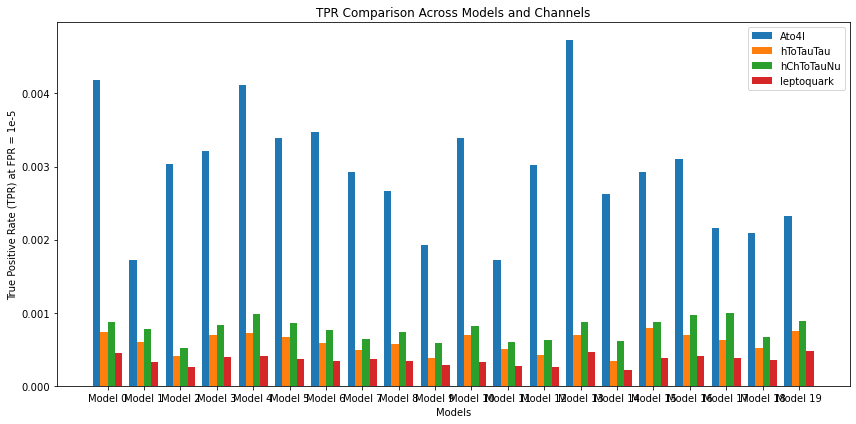


Channel Statistics:
Ato4l: Mean TPR = 0.0029, Std Dev = 0.0008
hToTauTau: Mean TPR = 0.0006, Std Dev = 0.0001
hChToTauNu: Mean TPR = 0.0008, Std Dev = 0.0001
leptoquark: Mean TPR = 0.0004, Std Dev = 0.0001


In [20]:
if channel_results:
    plt.figure(figsize=(12, 6))
    channels = list(channel_results.keys())
    n_channels = len(channels)
    n_models = len(channel_results[channels[0]])
    
    x = np.arange(n_models)
    width = 0.8 / n_channels
    
    for i, channel in enumerate(channels):
        tprs = channel_results[channel]
        plt.bar(x + i * width, tprs, width, label=channel)
    
    plt.xlabel('Models')
    plt.ylabel('True Positive Rate (TPR) at FPR = 1e-5')
    plt.title('TPR Comparison Across Models and Channels')
    plt.xticks(x + width * (n_channels - 1) / 2, [f'Model {i}' for i in range(n_models)])
    plt.legend()
    plt.tight_layout()
    plt.savefig('VAE_tpr_comparison_plot.png', dpi=600, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nChannel Statistics:")
    for channel in channels:
        tprs = channel_results[channel]
        mean = np.mean(tprs)
        std = np.std(tprs)
        print(f"{channel}: Mean TPR = {mean:.4f}, Std Dev = {std:.4f}")
else:
    print("No results were obtained. Cannot create comparison plot.")

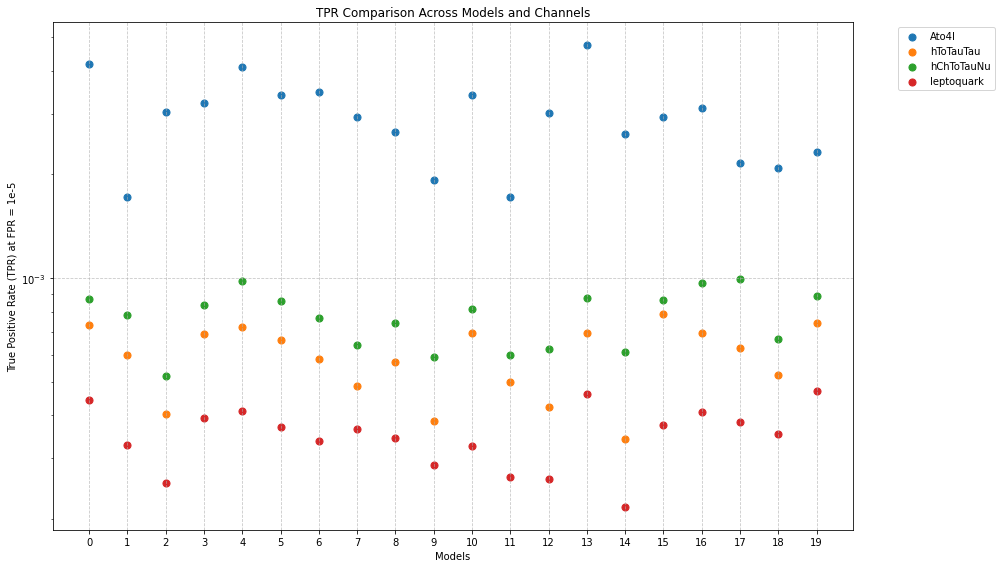


Channel Statistics:
Ato4l: Mean TPR = 0.0029, Std Dev = 0.0008
hToTauTau: Mean TPR = 0.0006, Std Dev = 0.0001
hChToTauNu: Mean TPR = 0.0008, Std Dev = 0.0001
leptoquark: Mean TPR = 0.0004, Std Dev = 0.0001


In [21]:
if channel_results:
    plt.figure(figsize=(14, 8))  # Increased figure size to accommodate the legend
    channels = list(channel_results.keys())
    n_channels = len(channels)
    n_models = len(channel_results[channels[0]])
    
    for i, channel in enumerate(channels):
        tprs = channel_results[channel]
        plt.scatter(range(n_models), tprs, label=channel, s=50)
    
    plt.xlabel('Models')
    plt.ylabel('True Positive Rate (TPR) at FPR = 1e-5')
    plt.semilogy()
    plt.title('TPR Comparison Across Models and Channels')
    plt.xticks(range(n_models), [f'{i}' for i in range(n_models)])
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Place legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig('VAE_tpr_comparison_plot.png', dpi=600, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nChannel Statistics:")
    for channel in channels:
        tprs = channel_results[channel]
        mean = np.mean(tprs)
        std = np.std(tprs)
        print(f"{channel}: Mean TPR = {mean:.4f}, Std Dev = {std:.4f}")
else:
    print("No results were obtained. Cannot create comparison plot.")

In [ ]:
Losses=['MSE']
for string in Losses:
    evaluation=Model_Evaluator('/eos/user/h/hjia/AnomalyDetection/trained_models/VAE_model/versionlarge/',
                               X_test,
                               np.ones(len(X_test)),
                               signal_data,
                               [np.ones(len(Ato4l_data)),
                                    np.ones(len(hToTauTau_data)),
                                    np.ones(len(hChToTauNu_data)),
                                    np.ones(len(leptoquark_data))],
                               input_dim = X_test.shape[1],
                               title='VAE Model',
                               save = False,
                               labels = signal_labels)
#     A2_MSE=evaluation.calculate_loss('MSE')[0]
    A2_loss=evaluation.calculate_loss(string)[1][0]
    evaluation.ROC()

In [23]:
T2A.predict(Ato4l_data)
tf.keras.models.save_model(T2A, 'VAE_40MHZ_model_Vlarge', save_format='tf')

1750/1750 [==============================] - 4s 2ms/step
INFO:tensorflow:Assets written to: VAE_40MHZ_model_Vlarge/assets


INFO:tensorflow:Assets written to: VAE_40MHZ_model_Vlarge/assets


10642/10642 [==============================] - 21s 2ms/step


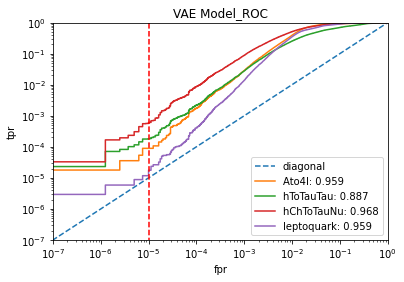


TPR at FPR = 1e-05 for each channel:
Ato4l: 0.008934%, Theshold = 21.682049
hToTauTau: 0.017793%, Theshold = 23.073204
hChToTauNu: 0.056559%, Theshold = 23.073204
leptoquark: 0.001175%, Theshold = 23.073204


In [22]:
Losses=['KL']
for string in Losses:
    evaluation=Model_Evaluator('/eos/user/h/hjia/AnomalyDetection/trained_models/VAE_model/versionlarge/',
                               X_test,
                               np.ones(len(X_test)),
                               signal_data,
                               [np.ones(len(Ato4l_data)),
                                    np.ones(len(hToTauTau_data)),
                                    np.ones(len(hChToTauNu_data)),
                                    np.ones(len(leptoquark_data))],
                               input_dim = X_test.shape[1],
                               title='VAE Model',
                               save = False,
                               labels = signal_labels)
#     A2_MSE=evaluation.calculate_loss('MSE')[0]
    A2_loss=evaluation.calculate_loss(string)[1][0]
    evaluation.ROC()

In [21]:
ori_vae_enc = Qmake_encoder_set_weights(57,128,64,32,16)
ori_vae_dec = Qmake_decoder_set_weights(57,128,64,32,16)
orginal_model = VAE_Model(ori_vae_enc, ori_vae_dec)
orginal_model.load_weights("/eos/user/h/hjia/AnomalyDetection/trained_models/VAE_model/versionlarge/")


def make_simplified_encoder(input_dim, h_dim_1, h_dim_2, latent_dim):
    inputs = keras.Input(shape=(input_dim,), name='inputs')
    x = BatchNormalization(name="BN0")(inputs)
    x = Dense(h_dim_1,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             name = "dense1")(x)
    x = BatchNormalization(name="BN1")(x)
    x = ReLU(name="relu1")(x)
    x = Dense(h_dim_2,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             name = "dense2")(x)    
    x = BatchNormalization(name="BN2")(x)
    x = ReLU(name="relu2")(x)
    z_mean=Dense(latent_dim, name='z_mean',
                  kernel_initializer=keras.initializers.HeNormal(seed=None),
                  bias_initializer=keras.initializers.Zeros())(x)
    new_encoder = keras.Model(inputs,z_mean,name='encoder')
    return new_encoder

In [22]:
new_encoder = make_simplified_encoder(57,128,64,32,16)
# Transfer weights from the original encoder
for layer in new_encoder.layers:
    original_layer = ori_vae_enc.get_layer(layer.name)
    if original_layer is not None:
        print("set weight for ", layer)
        print(original_layer.get_weights())
        layer.set_weights(original_layer.get_weights())

set weight for  <keras.src.engine.input_layer.InputLayer object at 0x7f1af72c3190>
[]
set weight for  <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f1af72c3940>
[array([ 2.1417964 ,  1.        ,  0.13130373,  1.4882108 ,  0.16339432,
        0.10698679,  2.8380601 ,  0.1449453 ,  0.15614474, -1.440482  ,
        0.11288233,  0.09331421,  1.5620621 , -0.22688495,  0.21106279,
        1.5095345 ,  0.13393608,  0.09039768,  1.708957  ,  0.16496909,
        0.13906915,  0.02163002,  0.17120202,  0.12403483,  1.498481  ,
        0.47445717,  0.24674042,  1.445754  ,  0.16470414,  0.1398548 ,
        1.4728975 ,  0.12641142,  0.15272439,  1.909903  ,  0.11207964,
        0.11177876,  2.8153298 ,  0.1128623 ,  0.12961161,  3.1458733 ,
        0.10582617,  0.12754774,  3.1803873 ,  0.10025217,  0.10223963,
        0.3344309 ,  0.10400185,  0.09967288,  0.2574598 ,  0.07677589,
        0.1056692 , -0.15584543,  0.09519085,  0.08615083,  0.33661127,
       -

In [23]:
tf.keras.models.save_model(new_encoder, 'VAE_40MHZ_model_Vlarge', save_format='tf')

INFO:tensorflow:Assets written to: VAE_40MHZ_model_Vlarge/assets


INFO:tensorflow:Assets written to: VAE_40MHZ_model_Vlarge/assets
